# Evaluation
In diesem Notebook soll die bestehende Genderassistenz mit den Testdaten evaluiert werden. Zunächst wird dafür für den Artikel die Position seiner markierten Wörter und die Information ob diese Gegendert werden müssen gespeichert.

In [1]:
import pandas as pd
import loguru
from loguru import logger
import spacy
from collections import defaultdict
from tqdm import tqdm
import language_tool_python
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import json


os.environ["TOKENIZERS_PARALLELISM"] = "false"
tool = language_tool_python.LanguageTool('de')

# Enable tqdm in pandas
tqdm.pandas()

nlp = spacy.load("de_dep_news_trf")

# Remove the default handler (which logs everything from DEBUG)
logger.remove()

# Add a new handler with a specific log level, e.g. INFO
logger.add(lambda msg: print(msg, end=""), level="INFO")

/opt/anaconda3/envs/spacy310/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'de_dep_news_trf' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.8.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


1

In [274]:
df = pd.read_pickle('data_prepared_frame.pkl')


In [275]:
def add_marked_word_information(article: str) -> list[dict]:
    """
    Extrahiert alle markierten Wörter im Format !--wort-- oder \\--wort-- aus einem Artikel
    und gibt ihre Positionen im bereinigten Text sowie das ntbg-Flag zurück.

    Rückgabe: Liste von Dicts mit:
        - word: das markierte Wort
        - word_begin: Startindex im bereinigten Text
        - word_end: Endindex im bereinigten Text
        - ntbg: True bei !--..., False bei \\--...
    """
    result = []
    ci = 0
    output_index = 0  # Position im bereinigten Text

    while ci < len(article) - 2:
        if article[ci] in ("!", "\\") and article[ci+1:ci+3] == "--":
            ntbg = article[ci] == "!"
            ci += 3  # springe über !-- oder \--

            word = ""
            start_index = output_index

            while ci < len(article) - 1:
                if article[ci:ci+2] == "--":
                    end_index = output_index
                    result.append({
                        "word": word,
                        "from": start_index,
                        "to": end_index,
                        "ntbg": ntbg
                    })
                    ci += 2
                    break

                word += article[ci]
                ci += 1
                output_index += 1

            continue

        # Nicht markierter Text → einfach weiterzählen
        ci += 1
        output_index += 1

    return result

In [276]:
df['marked_word_information'] = df['Text'].apply(add_marked_word_information)
df['spacified_article'] = df['Text_unmarked'].progress_apply(nlp)

  0%|                                                  | 0/2265 [00:00<?, ?it/s]/opt/anaconda3/envs/spacy310/lib/python3.10/site-packages/thinc/shims/pytorch.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):
100%|███████████████████████████████████████| 2265/2265 [07:51<00:00,  4.80it/s]


In [277]:
df.to_pickle('local-store/data_prepared_frame_including_spcacy_information.pkl') # nur lokale zwischenspeicherung nicht commiten

Zunächst wollen wir die Pipeline auf alle Artikel anwenden. 

In [3]:
from pipeline.full_pipeline import full_pipeline

In [278]:
response = full_pipeline(df['Text_unmarked'].iloc[5])


/opt/anaconda3/envs/spacy310/lib/python3.10/site-packages/thinc/shims/pytorch.py:109: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


In [279]:
df['pipeline_result'] = df['Text_unmarked'].progress_apply(full_pipeline)

  0%|                                          | 4/2265 [00:04<53:30,  1.42s/it]

[Faktor]
2025-05-10 10:03:22.146 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:03:22.154 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  0%|                                          | 5/2265 [00:06<49:39,  1.32s/it]

[LKA-Fahnder]
2025-05-10 10:03:23.137 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[LKA-Fahnder]
2025-05-10 10:03:23.146 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


  0%|▏                                         | 8/2265 [00:08<36:31,  1.03it/s]

[Kantonstierarzt]
2025-05-10 10:03:25.542 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kantonstierarzt]
2025-05-10 10:03:25.551 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  0%|▏                                        | 10/2265 [00:11<47:00,  1.25s/it]

[sich, Revolutionsgardisten]
2025-05-10 10:03:28.569 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[sich, Revolutionsgardisten]
2025-05-10 10:03:28.575 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Revolutionsgardisten]
2025-05-10 10:03:28.617 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Revolutionsgardisten]
2025-05-10 10:03:28.622 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  0%|▏                                        | 11/2265 [00:12<46:07,  1.23s/it]

[Ex-Kollege]
2025-05-10 10:03:31.312 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Kollege]
2025-05-10 10:03:31.321 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  1%|▎                                        | 19/2265 [00:19<22:34,  1.66it/s]

[Reaktor]
2025-05-10 10:03:36.834 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:03:36.843 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  1%|▍                                        | 24/2265 [00:21<13:26,  2.78it/s]

[Aufsichtsrates]
2025-05-10 10:03:38.382 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrates]
2025-05-10 10:03:38.390 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  1%|▍                                        | 27/2265 [00:25<32:16,  1.16it/s]

[Hongkong-Chinesen, den]
2025-05-10 10:03:42.172 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Hongkong-Chinesen, den]
2025-05-10 10:03:42.181 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


  1%|▌                                        | 28/2265 [00:26<32:42,  1.14it/s]

2025-05-10 10:03:43.061 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Fetisch': Es darf nur ein Element mit dieser Beziehung geben. (sind mit sb, war aber [hat, Kurilen-Inseln])


  2%|▋                                        | 38/2265 [00:30<11:08,  3.33it/s]

[Arbeitgeber]
2025-05-10 10:03:47.236 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: Es darf nur ein Element mit dieser Beziehung geben. (Arbeitgeber mit cd, war aber [und, sondern])


  2%|▊                                        | 43/2265 [00:31<08:06,  4.57it/s]

[Hauptrivalen]
2025-05-10 10:03:48.322 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Hauptrivalen]
2025-05-10 10:03:48.331 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  2%|▉                                        | 49/2265 [00:32<07:23,  5.00it/s]

[Mendez-Fans]
2025-05-10 10:03:49.654 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Mendez-Fans]
2025-05-10 10:03:49.662 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


  3%|█                                        | 61/2265 [00:35<09:20,  3.93it/s]

[US-Drogenfahnder]
2025-05-10 10:03:52.849 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Drogenfahnder]
2025-05-10 10:03:52.859 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[US-Drogenfahnder]
2025-05-10 10:03:52.925 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Drogenfahnder]
2025-05-10 10:03:52.936 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  3%|█▎                                       | 72/2265 [00:38<07:38,  4.78it/s]

[Hochzeitsgäste]
2025-05-10 10:03:55.660 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Hochzeitsgäste]
2025-05-10 10:03:55.669 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Hochzeitsgäste]
2025-05-10 10:03:55.695 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Hochzeitsgäste]
2025-05-10 10:03:55.704 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


  4%|█▍                                       | 81/2265 [00:41<16:33,  2.20it/s]

2025-05-10 10:03:59.749 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Bekannter': Es darf nur ein Element mit dieser Beziehung geben. (ist mit sb, war aber [Premier, Ministerpräsident])


  4%|█▌                                       | 87/2265 [00:44<12:39,  2.87it/s]

[UN-Chef]
2025-05-10 10:04:01.891 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Chef]
2025-05-10 10:04:01.900 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[UN-Generalsekretär]
2025-05-10 10:04:01.952 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Generalsekretär]
2025-05-10 10:04:01.961 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[UN-Chef]
2025-05-10 10:04:02.033 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Chef]
2025-05-10 10:04:02.042 

  4%|█▌                                       | 88/2265 [00:45<17:48,  2.04it/s]

[UN-Chefs]
2025-05-10 10:04:02.139 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Chefs]
2025-05-10 10:04:02.147 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  4%|█▋                                       | 91/2265 [00:48<28:07,  1.29it/s]

[Bundesrat]
2025-05-10 10:04:05.049 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:04:05.055 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[CDU-Finanzexperte]
2025-05-10 10:04:05.084 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[CDU-Finanzexperte]
2025-05-10 10:04:05.093 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  4%|█▋                                       | 93/2265 [00:48<23:41,  1.53it/s]

[Regierungschefs]
2025-05-10 10:04:05.994 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: Es darf nur ein Element mit dieser Beziehung geben. (Regierungschefs mit cd, war aber [und, und])


  4%|█▋                                       | 95/2265 [00:50<22:43,  1.59it/s]

[Mifa-Arbeitnehmer]
2025-05-10 10:04:07.265 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Mifa-Arbeitnehmer]
2025-05-10 10:04:07.275 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


  4%|█▊                                      | 100/2265 [00:53<22:29,  1.60it/s]

[Grenzbeamter]
2025-05-10 10:04:10.412 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: object of type 'NoneType' has no len()
[Grenzbeamter]
2025-05-10 10:04:10.416 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: object of type 'NoneType' has no len()


  5%|█▉                                      | 107/2265 [00:57<17:21,  2.07it/s]

[Reaktor]
2025-05-10 10:04:14.423 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:04:14.431 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  5%|█▉                                      | 108/2265 [00:57<16:17,  2.21it/s]

[UN-Vertretern]
2025-05-10 10:04:14.718 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Vertretern]
2025-05-10 10:04:14.726 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


  5%|█▉                                      | 109/2265 [00:57<14:41,  2.45it/s]

[Zentralrat]
2025-05-10 10:04:14.989 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Zentralrat]
2025-05-10 10:04:14.998 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Zentralrat]
2025-05-10 10:04:15.018 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Zentralrat]
2025-05-10 10:04:15.027 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  5%|█▉                                      | 113/2265 [00:59<13:13,  2.71it/s]

[Bundesrat]
2025-05-10 10:04:16.358 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:04:16.364 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  5%|██                                      | 119/2265 [01:00<08:39,  4.13it/s]

[KP-Chef]
2025-05-10 10:04:17.577 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[KP-Chef]
2025-05-10 10:04:17.586 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[seinen, KP-Führer]
2025-05-10 10:04:17.697 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[seinen, KP-Führer]
2025-05-10 10:04:17.705 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  6%|██▎                                     | 132/2265 [01:03<11:38,  3.05it/s]

[Wissenschaftsrat]
2025-05-10 10:04:20.771 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Wissenschaftsrat]
2025-05-10 10:04:20.780 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Wissenschaftsrat]
2025-05-10 10:04:20.794 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Wissenschaftsrat]
2025-05-10 10:04:20.802 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  7%|██▊                                     | 161/2265 [01:13<20:44,  1.69it/s]

[Wissenschaftsrat]
2025-05-10 10:04:30.502 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Wissenschaftsrat]
2025-05-10 10:04:30.511 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Wissenschaftsrates]
2025-05-10 10:04:30.542 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Wissenschaftsrates]
2025-05-10 10:04:30.550 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Wissenschaftsrat]
2025-05-10 10:04:30.627 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Wissen

  7%|██▉                                     | 165/2265 [01:15<17:30,  2.00it/s]

[Kasko-Kunden]
2025-05-10 10:04:32.525 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kasko-Kunden]
2025-05-10 10:04:32.533 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


  7%|██▉                                     | 166/2265 [01:16<24:48,  1.41it/s]

[Ex-Terroristen]
2025-05-10 10:04:33.680 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Terroristen]
2025-05-10 10:04:33.689 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


  7%|██▉                                     | 169/2265 [01:18<21:37,  1.62it/s]

[Siemens-Chef]
2025-05-10 10:04:36.390 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Siemens-Chef]
2025-05-10 10:04:36.399 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  8%|███                                     | 170/2265 [01:19<25:18,  1.38it/s]

[Reaktoren]
2025-05-10 10:04:36.668 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Reaktoren]
2025-05-10 10:04:36.677 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


  8%|███▏                                    | 184/2265 [01:25<14:53,  2.33it/s]

[G-7-Chefs]
2025-05-10 10:04:42.228 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[G-7-Chefs]
2025-05-10 10:04:42.236 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


  9%|███▍                                    | 194/2265 [01:26<04:28,  7.70it/s]

[Brummi-Fahrer]
2025-05-10 10:04:45.571 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Brummi-Fahrer]
2025-05-10 10:04:45.580 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


  9%|███▌                                    | 204/2265 [01:32<15:03,  2.28it/s]

[Bundesrat]
2025-05-10 10:04:50.014 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:04:50.020 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


  9%|███▊                                    | 214/2265 [01:35<13:59,  2.44it/s]

[UN-Inspektoren]
2025-05-10 10:04:52.801 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Inspektoren]
2025-05-10 10:04:52.810 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 10%|███▊                                    | 218/2265 [01:36<07:59,  4.27it/s]

[Ältestenrat]
2025-05-10 10:04:53.479 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ältestenrat]
2025-05-10 10:04:53.487 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Ältestenrat]
2025-05-10 10:04:53.516 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ältestenrat]
2025-05-10 10:04:53.525 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Ältestenrat]
2025-05-10 10:04:53.553 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ältestenrat]
2025-05-10 10:04:53.56

 10%|███▉                                    | 222/2265 [01:37<10:32,  3.23it/s]

[Boge-Aktionäre]
2025-05-10 10:04:54.663 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Boge-Aktionäre]
2025-05-10 10:04:54.671 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 10%|████▏                                   | 237/2265 [01:40<05:35,  6.04it/s]

2025-05-10 10:04:57.699 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: hatt
[Vorgänger, er]
2025-05-10 10:04:57.699 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: hatt
2025-05-10 10:04:57.713 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: hatt
[Vorgänger, er]
2025-05-10 10:04:57.713 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: hatt


 11%|████▏                                   | 239/2265 [01:41<07:54,  4.27it/s]

[Fachhochschulprofessors]
2025-05-10 10:04:58.301 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Fachhochschulprofessors]
2025-05-10 10:04:58.307 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 11%|████▍                                   | 248/2265 [01:44<12:33,  2.68it/s]

[Taxifahrer]
2025-05-10 10:05:01.184 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Taxifahrer]
2025-05-10 10:05:01.190 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 11%|████▍                                   | 251/2265 [01:45<13:30,  2.48it/s]

[Faktor]
2025-05-10 10:05:02.397 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:05:02.406 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 11%|████▌                                   | 256/2265 [01:47<13:55,  2.40it/s]

[US-Minister, seine]
2025-05-10 10:05:04.392 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Minister, seine]
2025-05-10 10:05:04.401 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 12%|████▊                                   | 270/2265 [01:50<08:12,  4.05it/s]

2025-05-10 10:05:07.702 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Kriegsherr': 'NN'
2025-05-10 10:05:07.708 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'einer': 'NoneType' object is not iterable
2025-05-10 10:05:07.715 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Baumeister': 'NoneType' object is not iterable


 13%|█████                                   | 285/2265 [01:55<08:32,  3.87it/s]

[Scotland-Yard-Sprecher]
2025-05-10 10:05:12.168 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Scotland-Yard-Sprecher]
2025-05-10 10:05:12.177 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 13%|█████                                   | 290/2265 [01:56<09:58,  3.30it/s]

2025-05-10 10:05:13.652 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Juden': 'NN'


 13%|█████▏                                  | 291/2265 [01:57<13:57,  2.36it/s]

[Student, seiner]
2025-05-10 10:05:14.241 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Student, seiner]
2025-05-10 10:05:14.243 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 13%|█████▏                                  | 292/2265 [01:58<19:22,  1.70it/s]

2025-05-10 10:05:15.332 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: erfuhre
[Freischärler, sie]
2025-05-10 10:05:15.332 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: erfuhre
2025-05-10 10:05:15.342 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: erfuhre
[Freischärler, sie]
2025-05-10 10:05:15.342 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: erfuhre


 13%|█████▏                                  | 294/2265 [01:59<16:46,  1.96it/s]

[Vorbehalten]
2025-05-10 10:05:16.286 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Vorbehalten]
2025-05-10 10:05:16.291 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
2025-05-10 10:05:17.179 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Demonstranten': 'NN'
2025-05-10 10:05:17.374 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'einen': 'NoneType' object is not iterable


 13%|█████▏                                  | 296/2265 [02:00<17:17,  1.90it/s]

2025-05-10 10:05:17.384 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Friedensstifter': 'NN'


 13%|█████▎                                  | 298/2265 [02:02<24:58,  1.31it/s]

[Heiligen]
2025-05-10 10:05:19.087 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Heiligen]
2025-05-10 10:05:19.087 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Fremde]
2025-05-10 10:05:19.100 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Fremde]
2025-05-10 10:05:19.100 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 13%|█████▎                                  | 300/2265 [02:03<23:34,  1.39it/s]

[Verwaltungsangestellten]
2025-05-10 10:05:23.538 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Verwaltungsangestellten]
2025-05-10 10:05:23.538 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 13%|█████▎                                  | 302/2265 [02:08<48:31,  1.48s/it]

[Generatoren]
2025-05-10 10:05:25.392 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Generatoren]
2025-05-10 10:05:25.401 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 13%|█████▍                                  | 305/2265 [02:09<25:53,  1.26it/s]

[Faktor]
2025-05-10 10:05:29.754 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:05:29.763 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
2025-05-10 10:05:30.197 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Arbeitgeber': 'NN'


 14%|█████▍                                  | 307/2265 [02:14<47:34,  1.46s/it]

[Schulräte]
2025-05-10 10:05:31.326 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Schulräte]
2025-05-10 10:05:31.332 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Schulräte]
2025-05-10 10:05:31.364 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Schulräte]
2025-05-10 10:05:31.370 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:05:31.393 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:05:31.402 | INFO     |

 14%|█████▍                                  | 310/2265 [02:15<26:07,  1.25it/s]

2025-05-10 10:05:35.348 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Sicherheitsfanatiker': Es darf nur ein Element mit dieser Beziehung geben. (blieb mit sb, war aber [verlor, Haudegen])


 14%|█████▌                                  | 312/2265 [02:19<38:29,  1.18s/it]

2025-05-10 10:05:37.721 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'er': 'NoneType' object is not iterable
2025-05-10 10:05:37.721 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Schauspieler': 'NN'
2025-05-10 10:05:37.822 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Regisseur': 'NN'
[Gerichtsreporters, seiner]
2025-05-10 10:05:37.843 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Gerichtsreporters, seiner]
2025-05-10 10:05:37.844 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 14%|█████▌                                  | 314/2265 [02:21<32:11,  1.01it/s]

[Einlagenfabrikanten]
2025-05-10 10:05:38.239 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Einlagenfabrikanten]
2025-05-10 10:05:38.249 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 14%|█████▌                                  | 316/2265 [02:21<22:20,  1.45it/s]

[Einlagenfabrikanten]
2025-05-10 10:05:39.032 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Einlagenfabrikanten]
2025-05-10 10:05:39.041 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 14%|█████▋                                  | 320/2265 [02:24<23:19,  1.39it/s]

[CDU-Vorsitzende, sein]
2025-05-10 10:05:41.648 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[CDU-Vorsitzende, sein]
2025-05-10 10:05:41.648 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 14%|█████▋                                  | 322/2265 [02:25<20:53,  1.55it/s]

2025-05-10 10:05:44.527 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'er': 'NoneType' object is not iterable
2025-05-10 10:05:44.527 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Ministerpräsident': 'NN'
2025-05-10 10:05:44.713 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Mörder': 'NN'
[Verräter]
2025-05-10 10:05:44.738 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Verräter]
2025-05-10 10:05:44.739 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
2025-05-10 10:05:44.832 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Chef': 'NN'
2025-05-10 10:05:44.838 | ERROR    | pipeline.full_pipeli

 14%|█████▊                                  | 326/2265 [02:31<40:38,  1.26s/it]

[Bundesgenossen]
2025-05-10 10:05:48.748 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesgenossen]
2025-05-10 10:05:48.754 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 14%|█████▊                                  | 328/2265 [02:32<27:06,  1.19it/s]

[Ex-Minister]
2025-05-10 10:05:49.622 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Minister]
2025-05-10 10:05:49.631 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 15%|██████                                  | 340/2265 [02:37<11:13,  2.86it/s]

[Berufskraftfahrer]
2025-05-10 10:05:54.590 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Berufskraftfahrer]
2025-05-10 10:05:54.601 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 15%|██████▏                                 | 348/2265 [02:40<14:53,  2.15it/s]

2025-05-10 10:05:57.937 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Gott': 'NN'


 15%|██████▏                                 | 349/2265 [02:41<18:01,  1.77it/s]

[apo-E-4-Träger]
2025-05-10 10:05:58.700 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[apo-E-4-Träger]
2025-05-10 10:05:58.709 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 16%|██████▍                                 | 365/2265 [02:45<08:05,  3.91it/s]

[UN-Soldaten]
2025-05-10 10:06:03.340 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Soldaten]
2025-05-10 10:06:03.349 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[UN-Sprecher]
2025-05-10 10:06:03.414 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Sprecher]
2025-05-10 10:06:03.423 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Sektoren]
2025-05-10 10:06:03.519 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektoren]
2025-05-10 10:06:03.528 | 

 16%|██████▍                                 | 367/2265 [02:46<10:21,  3.05it/s]

[Sektoren]
2025-05-10 10:06:03.550 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 16%|██████▌                                 | 373/2265 [02:48<10:32,  2.99it/s]

2025-05-10 10:06:05.576 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'einen': 'NoneType' object is not iterable
2025-05-10 10:06:05.587 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Algerier': 'NN'


 17%|██████▌                                 | 374/2265 [02:48<11:33,  2.73it/s]

[UN-Soldaten]
2025-05-10 10:06:05.887 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Soldaten]
2025-05-10 10:06:05.895 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[UN-Soldaten]
2025-05-10 10:06:05.935 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Soldaten]
2025-05-10 10:06:05.943 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Sektoren]
2025-05-10 10:06:06.030 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektoren]
2025-05-10 10:06:06.039 

 17%|██████▋                                 | 378/2265 [02:49<09:05,  3.46it/s]

[US-Bürger]
2025-05-10 10:06:06.922 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Bürger]
2025-05-10 10:06:06.931 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[US-Bürger]
2025-05-10 10:06:06.943 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Bürger]
2025-05-10 10:06:06.952 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 17%|██████▊                                 | 384/2265 [02:51<07:53,  3.97it/s]

[Getränkedosenhersteller]
2025-05-10 10:06:08.306 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Getränkedosenhersteller]
2025-05-10 10:06:08.316 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 17%|██████▊                                 | 385/2265 [02:51<09:00,  3.48it/s]

[Aufsichtsrat]
2025-05-10 10:06:08.555 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:06:08.563 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Oberfranke]
2025-05-10 10:06:08.659 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Oberfranke]
2025-05-10 10:06:08.669 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 17%|██████▊                                 | 388/2265 [02:52<12:43,  2.46it/s]

[Arbeitnehmern]
2025-05-10 10:06:09.806 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: Es darf nur ein Element mit dieser Beziehung geben. (Arbeitnehmern mit cd, war aber [sowohl, als])


 17%|██████▉                                 | 392/2265 [02:58<35:31,  1.14s/it]

[Verrat]
2025-05-10 10:06:19.071 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Verrat]
2025-05-10 10:06:19.080 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 17%|██████▉                                 | 395/2265 [03:03<41:13,  1.32s/it]

[Anlagenbauer]
2025-05-10 10:06:21.987 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Anlagenbauer]
2025-05-10 10:06:21.994 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Anlagenbauer, sie]
2025-05-10 10:06:22.122 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Anlagenbauer, sie]
2025-05-10 10:06:22.127 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 18%|███████                                 | 402/2265 [03:11<34:29,  1.11s/it]

[CDU-Wähler]
2025-05-10 10:06:28.650 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[CDU-Wähler]
2025-05-10 10:06:28.659 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:06:32.413 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:06:32.419 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 18%|███████▏                                | 404/2265 [03:16<49:17,  1.59s/it]

[CDU-Wähler]
2025-05-10 10:06:33.278 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[CDU-Wähler]
2025-05-10 10:06:33.287 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 18%|███████▏                                | 408/2265 [03:19<33:05,  1.07s/it]

[Festspielintendant]
2025-05-10 10:06:36.829 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Festspielintendant]
2025-05-10 10:06:36.835 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 18%|███████▎                                | 413/2265 [03:21<14:37,  2.11it/s]

[Consors-Kunde]
2025-05-10 10:06:38.649 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Consors-Kunde]
2025-05-10 10:06:38.657 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:06:38.953 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:06:38.961 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Oberfranke, seinen]
2025-05-10 10:06:38.993 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Oberfranke, seinen]
20

 18%|███████▎                                | 414/2265 [03:21<14:45,  2.09it/s]

[SLD-Führer]
2025-05-10 10:06:40.068 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[SLD-Führer]
2025-05-10 10:06:40.076 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 18%|███████▍                                | 419/2265 [03:25<18:39,  1.65it/s]

[Lebensmittelwächter]
2025-05-10 10:06:42.134 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Lebensmittelwächter]
2025-05-10 10:06:42.143 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 19%|███████▍                                | 422/2265 [03:26<17:43,  1.73it/s]

[Aufsichtsrat]
2025-05-10 10:06:44.100 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:06:44.109 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 19%|███████▌                                | 425/2265 [03:28<12:19,  2.49it/s]

2025-05-10 10:06:45.191 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Begleiter': 'NN'


 19%|███████▌                                | 426/2265 [03:30<30:46,  1.00s/it]

[Beste]
2025-05-10 10:06:47.581 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Beste]
2025-05-10 10:06:47.586 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 19%|███████▌                                | 429/2265 [03:31<16:39,  1.84it/s]

[Ex-Jugoslawen]
2025-05-10 10:06:48.330 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Jugoslawen]
2025-05-10 10:06:48.340 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 19%|███████▌                                | 430/2265 [03:31<15:29,  1.97it/s]

[Ex-Kommunisten]
2025-05-10 10:06:48.788 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Kommunisten]
2025-05-10 10:06:48.797 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 19%|███████▌                                | 431/2265 [03:31<13:40,  2.24it/s]

[Ex-Kommunisten]
2025-05-10 10:06:49.056 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Kommunisten]
2025-05-10 10:06:49.065 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 19%|███████▊                                | 440/2265 [03:36<09:16,  3.28it/s]

[Lebensmittelwächter]
2025-05-10 10:06:53.510 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Lebensmittelwächter]
2025-05-10 10:06:53.519 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Ex-Präsidenten]
2025-05-10 10:06:54.871 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Präsidenten]
2025-05-10 10:06:54.880 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[AA-Chef]
2025-05-10 10:06:54.936 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[AA-Chef]
2025

 20%|███████▉                                | 448/2265 [03:43<20:52,  1.45it/s]

[Bundesrat]
2025-05-10 10:07:00.239 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:07:00.245 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 20%|███████▉                                | 451/2265 [03:44<13:26,  2.25it/s]

[UN-Beobachtern]
2025-05-10 10:07:01.159 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Beobachtern]
2025-05-10 10:07:01.168 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 20%|███████▉                                | 452/2265 [03:44<11:56,  2.53it/s]

[Ex-Professoren]
2025-05-10 10:07:01.414 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Professoren]
2025-05-10 10:07:01.423 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 20%|████████                                | 459/2265 [03:47<17:11,  1.75it/s]

[Gefreiten]
2025-05-10 10:07:04.355 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Gefreiten]
2025-05-10 10:07:04.356 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 20%|████████▏                               | 461/2265 [03:48<21:45,  1.38it/s]

[Verrat]
2025-05-10 10:07:06.062 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Verrat]
2025-05-10 10:07:06.071 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Ex-Chef, sich]
2025-05-10 10:07:06.110 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Chef, sich]
2025-05-10 10:07:06.119 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 22%|████████▊                               | 496/2265 [04:10<42:32,  1.44s/it]

[Gesangsmime, seinen]
2025-05-10 10:07:27.330 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Gesangsmime, seinen]
2025-05-10 10:07:27.338 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 22%|████████▊                               | 498/2265 [04:11<29:10,  1.01it/s]

2025-05-10 10:07:30.413 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'ihm': 'NoneType' object is not iterable
2025-05-10 10:07:30.414 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Geschäftsführer': 'NN'


 22%|████████▊                               | 501/2265 [04:14<25:24,  1.16it/s]

[Flugzeugbauer]
2025-05-10 10:07:31.418 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Flugzeugbauer]
2025-05-10 10:07:31.427 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 22%|████████▉                               | 503/2265 [04:15<22:21,  1.31it/s]

[Aufsichtsrat]
2025-05-10 10:07:32.767 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:07:32.776 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 22%|████████▉                               | 505/2265 [04:18<28:51,  1.02it/s]

2025-05-10 10:07:35.333 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Soldaten': 'NoneType' object is not iterable
2025-05-10 10:07:35.340 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Mörder': 'NoneType' object is not iterable
2025-05-10 10:07:35.340 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Soldaten': 'NN'


 23%|█████████                               | 514/2265 [04:22<16:29,  1.77it/s]

[sich, Politiker]
2025-05-10 10:07:40.106 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: Es darf nur ein Element mit dieser Beziehung geben. (Politiker mit cd, war aber [weder, noch])


 23%|█████████▏                              | 523/2265 [04:27<13:44,  2.11it/s]

[Anlagenbauer, ihr]
2025-05-10 10:07:44.281 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Anlagenbauer, ihr]
2025-05-10 10:07:44.286 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 23%|█████████▎                              | 528/2265 [04:30<15:34,  1.86it/s]

[Stabilitätsrat]
2025-05-10 10:07:47.159 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Stabilitätsrat]
2025-05-10 10:07:47.168 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 23%|█████████▍                              | 531/2265 [04:31<11:58,  2.41it/s]

2025-05-10 10:07:48.328 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: herausführe
[Taktiker]
2025-05-10 10:07:48.328 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: herausführe


 24%|█████████▍                              | 534/2265 [04:32<10:08,  2.85it/s]

2025-05-10 10:07:49.105 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'ihn': 'NoneType' object is not iterable
2025-05-10 10:07:49.108 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Serbenführer': 'NN'
[UN-Beauftragte, seine]
2025-05-10 10:07:49.144 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Beauftragte, seine]
2025-05-10 10:07:49.152 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 24%|█████████▌                              | 542/2265 [04:36<19:19,  1.49it/s]

[Veranstalters]
2025-05-10 10:07:53.187 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Veranstalters]
2025-05-10 10:07:53.187 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 24%|█████████▌                              | 544/2265 [04:37<15:59,  1.79it/s]

[Reaktor]
2025-05-10 10:07:54.017 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:07:54.026 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Forza-Italia-Politiker]
2025-05-10 10:07:54.127 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Forza-Italia-Politiker]
2025-05-10 10:07:54.135 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 24%|█████████▌                              | 545/2265 [04:37<12:36,  2.27it/s]

[KP-Funktionären]
2025-05-10 10:07:54.309 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[KP-Funktionären]
2025-05-10 10:07:54.319 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[KP-Funktionären]
2025-05-10 10:07:54.344 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[KP-Funktionären]
2025-05-10 10:07:54.354 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 24%|█████████▋                              | 546/2265 [04:37<13:54,  2.06it/s]

[Bundesrat]
2025-05-10 10:07:54.842 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:07:54.847 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 24%|█████████▊                              | 553/2265 [04:39<06:07,  4.66it/s]

[UN-Flüchtlingskommissars]
2025-05-10 10:07:56.478 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Flüchtlingskommissars]
2025-05-10 10:07:56.488 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 25%|█████████▊                              | 557/2265 [04:40<07:51,  3.62it/s]

[Neu-Verleger, seiner, dieser]
2025-05-10 10:07:57.597 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Neu-Verleger, seiner, dieser]
2025-05-10 10:07:57.606 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Neu-Verleger, seiner, dieser]
2025-05-10 10:07:57.625 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Neu-Verleger, seiner, dieser]
2025-05-10 10:07:57.634 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 25%|██████████▏                             | 577/2265 [04:46<06:30,  4.33it/s]

[Regierungsrates]
2025-05-10 10:08:03.515 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Regierungsrates]
2025-05-10 10:08:03.524 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Ogoni-Führer]
2025-05-10 10:08:03.554 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ogoni-Führer]
2025-05-10 10:08:03.562 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 26%|██████████▏                             | 579/2265 [04:47<11:56,  2.35it/s]

[BKA-Ermittler]
2025-05-10 10:08:04.634 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[BKA-Ermittler]
2025-05-10 10:08:04.645 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[BKA-Ermittlern]
2025-05-10 10:08:04.730 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[BKA-Ermittlern]
2025-05-10 10:08:04.740 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 26%|██████████▎                             | 582/2265 [04:48<10:25,  2.69it/s]

[Fernsehräten]
2025-05-10 10:08:05.705 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Fernsehräten]
2025-05-10 10:08:05.713 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 26%|██████████▎                             | 584/2265 [04:49<11:40,  2.40it/s]

[Notenbanker]
2025-05-10 10:08:06.591 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Notenbanker]
2025-05-10 10:08:06.600 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 26%|██████████▍                             | 588/2265 [04:50<08:58,  3.12it/s]

2025-05-10 10:08:07.949 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Medikamente-Exporteur': Es darf nur ein Element mit dieser Beziehung geben. (sei mit sb, war aber [war, Deutschland])


 26%|██████████▍                             | 589/2265 [04:51<09:50,  2.84it/s]

2025-05-10 10:08:10.047 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'ihn': 'NoneType' object is not iterable
2025-05-10 10:08:10.050 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Sinologen': 'NN'
2025-05-10 10:08:10.053 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Dauerstudenten': 'NN'
2025-05-10 10:08:10.059 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'der': 'NoneType' object is not iterable


 26%|██████████▍                             | 590/2265 [04:53<23:39,  1.18it/s]

2025-05-10 10:08:10.316 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Auftraggeber': Es darf nur ein Element mit dieser Beziehung geben. (ist mit sb, war aber [Ruetz, hat])


 26%|██████████▍                             | 591/2265 [04:53<22:16,  1.25it/s]

[Inhalte]
2025-05-10 10:08:15.598 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:08:15.603 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 26%|██████████▍                             | 593/2265 [05:01<57:29,  2.06s/it]

[Wirtschaftsfachmann]
2025-05-10 10:08:19.306 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Wirtschaftsfachmann]
2025-05-10 10:08:19.315 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 26%|██████████▌                             | 595/2265 [05:04<49:35,  1.78s/it]

[Inhalten]
2025-05-10 10:08:21.126 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalten]
2025-05-10 10:08:21.132 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Inhalte, die]
2025-05-10 10:08:21.174 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte, die]
2025-05-10 10:08:21.180 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 26%|██████████▌                             | 596/2265 [05:04<38:34,  1.39s/it]

[Bafög-Empfängern]
2025-05-10 10:08:23.459 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bafög-Empfängern]
2025-05-10 10:08:23.468 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:08:23.580 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:08:23.586 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 26%|██████████▌                             | 599/2265 [05:08<36:02,  1.30s/it]

[Studentenrat]
2025-05-10 10:08:25.239 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Studentenrat]
2025-05-10 10:08:25.247 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 27%|██████████▋                             | 602/2265 [05:11<29:18,  1.06s/it]

2025-05-10 10:08:28.151 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Kandidaten': Es darf nur ein Element mit dieser Beziehung geben. (sind mit sb, war aber [hat, Beide])


 27%|██████████▋                             | 603/2265 [05:11<25:36,  1.08it/s]

[Inhalte]
2025-05-10 10:08:28.782 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:08:28.788 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 27%|██████████▊                             | 609/2265 [05:15<20:18,  1.36it/s]

[Ex-Kommunisten]
2025-05-10 10:08:32.508 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Kommunisten]
2025-05-10 10:08:32.517 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
2025-05-10 10:08:32.536 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: Erhielte
[keiner]
2025-05-10 10:08:32.536 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: Erhielte


 27%|██████████▊                             | 613/2265 [05:17<15:02,  1.83it/s]

[Privatanleger]
2025-05-10 10:08:34.263 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Privatanleger]
2025-05-10 10:08:34.272 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Kreditgenossen]
2025-05-10 10:08:34.284 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kreditgenossen]
2025-05-10 10:08:34.293 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 28%|███████████▏                            | 630/2265 [05:26<12:53,  2.11it/s]

[Zustrom]
2025-05-10 10:08:44.341 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Zustrom]
2025-05-10 10:08:44.350 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 28%|███████████▏                            | 631/2265 [05:27<18:54,  1.44it/s]

[Inhalte]
2025-05-10 10:08:46.335 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:08:46.340 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 28%|███████████▏                            | 633/2265 [05:30<29:06,  1.07s/it]

[Verrat]
2025-05-10 10:08:47.425 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Verrat]
2025-05-10 10:08:47.434 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[US-Regisseure]
2025-05-10 10:08:47.557 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Regisseure]
2025-05-10 10:08:47.566 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 29%|███████████▍                            | 649/2265 [05:37<10:18,  2.61it/s]

[TV-Redakteure]
2025-05-10 10:08:55.851 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[TV-Redakteure]
2025-05-10 10:08:55.860 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Fernsehredakteuren]
2025-05-10 10:08:55.988 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Fernsehredakteuren]
2025-05-10 10:08:55.998 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 29%|███████████▍                            | 651/2265 [05:39<15:26,  1.74it/s]

[Kompromiß-Gegner]
2025-05-10 10:08:56.640 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kompromiß-Gegner]
2025-05-10 10:08:56.649 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 29%|███████████▌                            | 655/2265 [05:40<08:42,  3.08it/s]

[US-Richter]
2025-05-10 10:08:57.791 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Richter]
2025-05-10 10:08:57.800 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 29%|███████████▌                            | 657/2265 [05:41<12:16,  2.18it/s]

[UN-Soldaten]
2025-05-10 10:08:58.936 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Soldaten]
2025-05-10 10:08:58.944 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 29%|███████████▋                            | 664/2265 [05:43<06:23,  4.17it/s]

[GSG-9-Beamten]
2025-05-10 10:09:00.811 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[GSG-9-Beamten]
2025-05-10 10:09:00.820 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[GSG-9-Beamten]
2025-05-10 10:09:00.832 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[GSG-9-Beamten]
2025-05-10 10:09:00.841 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 30%|███████████▊                            | 670/2265 [05:45<10:05,  2.64it/s]

[Ex-Diktator]
2025-05-10 10:09:02.729 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Diktator]
2025-05-10 10:09:02.737 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Ex-Präsident, sich]
2025-05-10 10:09:02.819 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Präsident, sich]
2025-05-10 10:09:02.827 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 30%|███████████▉                            | 674/2265 [05:47<11:30,  2.31it/s]

2025-05-10 10:09:04.656 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'ihm': 'NoneType' object is not iterable


 30%|███████████▉                            | 679/2265 [05:49<11:43,  2.26it/s]

[Bundesrat]
2025-05-10 10:09:06.928 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:09:06.934 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:09:07.008 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:09:07.013 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 31%|████████████▎                           | 697/2265 [05:55<08:34,  3.05it/s]

[Sektor]
2025-05-10 10:09:14.179 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:09:14.188 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 31%|████████████▎                           | 698/2265 [05:57<19:50,  1.32it/s]

2025-05-10 10:09:16.056 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'er': 'NoneType' object is not iterable


 31%|████████████▍                           | 702/2265 [06:01<22:07,  1.18it/s]

[Schiffbauer]
2025-05-10 10:09:18.961 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Schiffbauer]
2025-05-10 10:09:18.969 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:09:19.005 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:09:19.015 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 31%|████████████▍                           | 703/2265 [06:02<21:31,  1.21it/s]

[Schiffbauer]
2025-05-10 10:09:19.172 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Schiffbauer]
2025-05-10 10:09:19.180 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 31%|████████████▌                           | 708/2265 [06:07<25:28,  1.02it/s]

[Muntermacher]
2025-05-10 10:09:24.431 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Muntermacher]
2025-05-10 10:09:24.441 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 31%|████████████▌                           | 712/2265 [06:12<33:50,  1.31s/it]

[Atomtestgegnern]
2025-05-10 10:09:30.118 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Atomtestgegnern]
2025-05-10 10:09:30.126 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 32%|████████████▋                           | 717/2265 [06:19<31:04,  1.20s/it]

2025-05-10 10:09:36.109 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Rentner': Es darf nur ein Element mit dieser Beziehung geben. (sind mit sb, war aber [FR-Leserin, Wir])
[EU-Experte]
2025-05-10 10:09:36.228 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Experte]
2025-05-10 10:09:36.237 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 32%|████████████▋                           | 719/2265 [06:21<29:22,  1.14s/it]

[Faktor]
2025-05-10 10:09:38.236 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:09:38.245 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 32%|████████████▊                           | 724/2265 [06:23<13:08,  1.95it/s]

[VW-Sprecher]
2025-05-10 10:09:40.385 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[VW-Sprecher]
2025-05-10 10:09:40.394 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 32%|████████████▊                           | 725/2265 [06:24<22:29,  1.14it/s]

2025-05-10 10:09:42.015 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Christen': 'NN'
[sich, EKD-Rat]
2025-05-10 10:09:42.122 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[sich, EKD-Rat]
2025-05-10 10:09:42.131 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 32%|████████████▉                           | 735/2265 [06:30<14:21,  1.78it/s]

[Bundesrat]
2025-05-10 10:09:47.603 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:09:47.609 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 33%|█████████████                           | 740/2265 [06:33<13:35,  1.87it/s]

[US-Politiker]
2025-05-10 10:09:50.335 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Politiker]
2025-05-10 10:09:50.344 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Demokraten]
2025-05-10 10:09:50.362 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: Es darf nur ein Element mit dieser Beziehung geben. (Demokraten mit cd, war aber [sowohl, als])
[Faktor]
2025-05-10 10:09:50.448 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:09:50.457 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nic

 33%|█████████████                           | 741/2265 [06:33<11:19,  2.24it/s]

[Taxifahrer]
2025-05-10 10:09:50.694 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Taxifahrer]
2025-05-10 10:09:50.700 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 33%|█████████████▏                          | 745/2265 [06:35<13:19,  1.90it/s]

[Bundesrat]
2025-05-10 10:09:52.572 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:09:52.578 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 33%|█████████████▏                          | 748/2265 [06:36<11:35,  2.18it/s]

[BA-Vertreter]
2025-05-10 10:09:53.665 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[BA-Vertreter]
2025-05-10 10:09:53.674 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 33%|█████████████▎                          | 753/2265 [06:39<12:06,  2.08it/s]

[Regierungsrat]
2025-05-10 10:09:57.547 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Regierungsrat]
2025-05-10 10:09:57.556 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Konsortialführer]
2025-05-10 10:09:57.614 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Konsortialführer]
2025-05-10 10:09:57.623 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[TV-Autor]
2025-05-10 10:09:57.655 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[TV-Autor]
2025-05-10 10:

 33%|█████████████▎                          | 754/2265 [06:40<19:12,  1.31it/s]

[US-Bürger]
2025-05-10 10:09:58.983 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Bürger]
2025-05-10 10:09:58.992 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Präzeptor]
2025-05-10 10:09:59.174 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Präzeptor]
2025-05-10 10:09:59.183 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 33%|█████████████▎                          | 756/2265 [06:42<17:27,  1.44it/s]

[Katalysator]
2025-05-10 10:09:59.236 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Katalysator]
2025-05-10 10:09:59.245 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 34%|█████████████▍                          | 760/2265 [06:43<12:09,  2.06it/s]

[Beamtenbund-Chef]
2025-05-10 10:10:01.051 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Beamtenbund-Chef]
2025-05-10 10:10:01.060 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 34%|█████████████▍                          | 763/2265 [06:45<12:12,  2.05it/s]

[Geschäftskunden]
2025-05-10 10:10:02.477 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Geschäftskunden]
2025-05-10 10:10:02.486 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 34%|█████████████▋                          | 776/2265 [06:50<06:47,  3.65it/s]

2025-05-10 10:10:07.449 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Emigranten': 'NN'


 35%|█████████████▊                          | 783/2265 [06:52<08:25,  2.93it/s]

[keiner]
2025-05-10 10:10:09.362 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[der]
2025-05-10 10:10:09.363 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
2025-05-10 10:10:09.510 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: lie
[sich, Prinz]
2025-05-10 10:10:09.510 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: lie


 35%|█████████████▉                          | 788/2265 [06:53<05:58,  4.12it/s]

2025-05-10 10:10:10.412 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'einer': 'NoneType' object is not iterable
2025-05-10 10:10:10.422 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Ballettdirektoren': 'NoneType' object is not iterable
2025-05-10 10:10:10.423 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Kenner': 'NN'


 35%|█████████████▉                          | 790/2265 [06:53<05:14,  4.68it/s]

2025-05-10 10:10:11.214 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Grünen-Politiker': 'NN'


 35%|██████████████                          | 796/2265 [06:55<06:17,  3.89it/s]

[UN-Vertreter]
2025-05-10 10:10:12.446 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Vertreter]
2025-05-10 10:10:12.455 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[UN-Vertreter]
2025-05-10 10:10:12.493 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Vertreter]
2025-05-10 10:10:12.502 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 35%|██████████████▏                         | 802/2265 [06:57<08:50,  2.76it/s]

[Atomtestgegnern]
2025-05-10 10:10:14.707 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Atomtestgegnern]
2025-05-10 10:10:14.715 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 36%|██████████████▏                         | 806/2265 [06:58<07:39,  3.17it/s]

2025-05-10 10:10:15.931 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: besitz
[Ausländer, er]
2025-05-10 10:10:15.931 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: besitz
2025-05-10 10:10:15.947 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: besitz
[Ausländer, er]
2025-05-10 10:10:15.947 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: besitz


 36%|██████████████▎                         | 808/2265 [06:59<06:22,  3.81it/s]

[US-Wissenschaftler]
2025-05-10 10:10:16.360 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Wissenschaftler]
2025-05-10 10:10:16.368 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 36%|██████████████▍                         | 814/2265 [07:01<08:45,  2.76it/s]

2025-05-10 10:10:18.189 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Befürworter': 'NN'


 36%|██████████████▌                         | 825/2265 [07:09<30:48,  1.28s/it]

[Niedersachse]
2025-05-10 10:10:27.940 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Niedersachse]
2025-05-10 10:10:27.946 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:10:28.213 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:10:28.222 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 37%|██████████████▌                         | 827/2265 [07:13<43:48,  1.83s/it]

[1600-Tonnen-Segler]
2025-05-10 10:10:30.744 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[1600-Tonnen-Segler]
2025-05-10 10:10:30.753 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 37%|██████████████▌                         | 828/2265 [07:15<40:58,  1.71s/it]

[Inhalte]
2025-05-10 10:10:32.255 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:10:32.261 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Sachverständigenrat, seinem]
2025-05-10 10:10:32.290 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sachverständigenrat, seinem]
2025-05-10 10:10:32.299 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:10:32.322 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-0

 37%|██████████████▋                         | 830/2265 [07:16<26:00,  1.09s/it]

[Hunde]
2025-05-10 10:10:36.360 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: Es darf nur ein Element mit dieser Beziehung geben. (Hunde mit cd, war aber [weder, noch])
[Bonivard-Pilger]
2025-05-10 10:10:36.555 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bonivard-Pilger]
2025-05-10 10:10:36.563 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Muntermacher, seine]
2025-05-10 10:10:36.741 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Muntermacher, seine]
2025-05-10 10:10:36.751 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvo

 37%|██████████████▋                         | 832/2265 [07:20<33:07,  1.39s/it]

[Wintersportmacher]
2025-05-10 10:10:38.510 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Wintersportmacher]
2025-05-10 10:10:38.520 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Tourismuswerber]
2025-05-10 10:10:38.782 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Tourismuswerber]
2025-05-10 10:10:38.792 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[TUI-Kunden]
2025-05-10 10:10:38.907 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[TUI-Kunden]


 37%|██████████████▊                         | 836/2265 [07:24<23:40,  1.01it/s]

[Niedersachsen]
2025-05-10 10:10:42.708 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Niedersachsen]
2025-05-10 10:10:42.717 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
2025-05-10 10:10:42.826 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: Fällt
[er]
2025-05-10 10:10:42.826 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: Fällt


 37%|██████████████▊                         | 838/2265 [07:26<24:53,  1.05s/it]

[Robinson-Kunden, davon]
2025-05-10 10:10:43.665 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Robinson-Kunden, davon]
2025-05-10 10:10:43.673 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 37%|██████████████▊                         | 842/2265 [07:31<32:36,  1.37s/it]

[Taxifahrer]
2025-05-10 10:10:48.724 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Taxifahrer]
2025-05-10 10:10:48.730 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 37%|██████████████▉                         | 843/2265 [07:32<31:05,  1.31s/it]

[Sektoren]
2025-05-10 10:10:49.845 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektoren]
2025-05-10 10:10:49.854 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 37%|██████████████▉                         | 847/2265 [07:34<16:49,  1.40it/s]

[Reisepaketanbieter, sich]
2025-05-10 10:10:51.967 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Reisepaketanbieter, sich]
2025-05-10 10:10:51.976 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 37%|██████████████▉                         | 848/2265 [07:35<14:58,  1.58it/s]

[Veranstalter, er]
2025-05-10 10:10:52.298 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: object of type 'NoneType' has no len()
[Veranstalter, er]
2025-05-10 10:10:52.298 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: object of type 'NoneType' has no len()
[Veranstalter, er]
2025-05-10 10:10:52.300 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: object of type 'NoneType' has no len()
[Veranstalter, er]
2025-05-10 10:10:52.300 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: object of type 'NoneType' has no len()


 38%|███████████████                         | 851/2265 [07:37<17:43,  1.33it/s]

2025-05-10 10:10:58.527 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Politiker': 'NN'
2025-05-10 10:10:59.056 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Mitarbeiter': 'NN'
[McKinsey-Forscher]
2025-05-10 10:10:59.113 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[McKinsey-Forscher]
2025-05-10 10:10:59.121 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 38%|███████████████                         | 853/2265 [07:42<31:57,  1.36s/it]

[Facharbeiter]
2025-05-10 10:11:03.994 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: Es darf nur ein Element mit dieser Beziehung geben. (Facharbeiter mit cd, war aber [oder, sondern])


 38%|███████████████                         | 856/2265 [07:49<42:17,  1.80s/it]

[sich, Judenhasser]
2025-05-10 10:11:06.673 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[sich, Judenhasser]
2025-05-10 10:11:06.683 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 38%|███████████████▏                        | 857/2265 [07:50<34:19,  1.46s/it]

[NS-Täter]
2025-05-10 10:11:07.316 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[NS-Täter]
2025-05-10 10:11:07.326 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Zustrom]
2025-05-10 10:11:07.367 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Zustrom]
2025-05-10 10:11:07.376 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 38%|███████████████▏                        | 863/2265 [07:55<26:10,  1.12s/it]

[Weltökonom]
2025-05-10 10:11:14.495 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Weltökonom]
2025-05-10 10:11:14.505 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Niedersachsen, seiner]
2025-05-10 10:11:14.677 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Niedersachsen, seiner]
2025-05-10 10:11:14.683 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Oberstratege]
2025-05-10 10:11:14.708 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Oberstratege]
20

 38%|███████████████▎                        | 864/2265 [07:57<34:46,  1.49s/it]

2025-05-10 10:11:15.953 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Ministerpräsident': Es darf nur ein Element mit dieser Beziehung geben. (wird mit sb, war aber [Nachfolger, Peres])


 38%|███████████████▎                        | 868/2265 [08:02<26:37,  1.14s/it]

[Bergbauern]
2025-05-10 10:11:21.243 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bergbauern]
2025-05-10 10:11:21.251 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Nebenerwerbsbauern]
2025-05-10 10:11:21.334 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Nebenerwerbsbauern]
2025-05-10 10:11:21.343 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 39%|███████████████▍                        | 874/2265 [08:08<20:16,  1.14it/s]

[Ex-Präsident, dessen]
2025-05-10 10:11:26.072 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Präsident, dessen]
2025-05-10 10:11:26.081 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Ex-Präsident, dessen]
2025-05-10 10:11:26.093 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Präsident, dessen]
2025-05-10 10:11:26.102 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Ex-Präsidenten]
2025-05-10 10:11:26.138 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of ran

 39%|███████████████▍                        | 877/2265 [08:10<13:01,  1.78it/s]

[Hotelangestellter]
2025-05-10 10:11:27.158 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Hotelangestellter]
2025-05-10 10:11:27.159 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 39%|███████████████▌                        | 882/2265 [08:12<13:04,  1.76it/s]

[Stabilitätsrat]
2025-05-10 10:11:29.847 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Stabilitätsrat]
2025-05-10 10:11:29.856 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 39%|███████████████▌                        | 883/2265 [08:12<11:00,  2.09it/s]

[Kaufinteressenten]
2025-05-10 10:11:30.101 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kaufinteressenten]
2025-05-10 10:11:30.110 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 39%|███████████████▋                        | 888/2265 [08:15<10:32,  2.18it/s]

[Parteivorsitzenden]
2025-05-10 10:11:32.308 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Parteivorsitzenden]
2025-05-10 10:11:32.314 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 39%|███████████████▋                        | 891/2265 [08:16<09:29,  2.41it/s]

2025-05-10 10:11:33.532 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: hinsegelt
[Passant, sich, er]
2025-05-10 10:11:33.532 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: hinsegelt
2025-05-10 10:11:33.549 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: hinsegelt
[Passant, sich, er]
2025-05-10 10:11:33.549 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: hinsegelt
2025-05-10 10:11:33.588 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: Weigert
[sich, Hauseigentümer]
2025-05-10 10:11:33.588 | INFO     | pipeline.correction.correction2:generate_possible_

 40%|███████████████▉                        | 899/2265 [08:18<06:48,  3.34it/s]

2025-05-10 10:11:36.150 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Kirchenparlamentarier': 'NN'


 40%|███████████████▉                        | 904/2265 [08:21<17:47,  1.28it/s]

[FDP-Strategen]
2025-05-10 10:11:39.081 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[FDP-Strategen]
2025-05-10 10:11:39.091 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 40%|████████████████                        | 910/2265 [08:24<12:08,  1.86it/s]

[CDU-Parlamentarier]
2025-05-10 10:11:42.023 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[CDU-Parlamentarier]
2025-05-10 10:11:42.032 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 40%|████████████████                        | 913/2265 [08:25<09:28,  2.38it/s]

2025-05-10 10:11:43.100 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: gleichsetzt
[Minister]
2025-05-10 10:11:43.100 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: gleichsetzt


 41%|████████████████▏                       | 919/2265 [08:28<09:52,  2.27it/s]

[US-Extremisten]
2025-05-10 10:11:45.702 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Extremisten]
2025-05-10 10:11:45.711 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 41%|████████████████▎                       | 924/2265 [08:29<06:16,  3.56it/s]

[VW-Sprecher]
2025-05-10 10:11:46.896 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[VW-Sprecher]
2025-05-10 10:11:46.905 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 41%|████████████████▍                       | 931/2265 [08:31<05:37,  3.95it/s]

[US-Zulieferer]
2025-05-10 10:11:48.837 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Zulieferer]
2025-05-10 10:11:48.847 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[BMW-Kunde]
2025-05-10 10:11:48.860 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[BMW-Kunde]
2025-05-10 10:11:48.870 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
2025-05-10 10:11:48.883 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: akzepiert
[Käufer]
2025-05-10 10:11:48.883 | INFO     | pipeline.correction.correction2:generate

 42%|████████████████▋                       | 943/2265 [08:35<05:44,  3.84it/s]

[Kleinstunternehmer]
2025-05-10 10:11:54.915 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kleinstunternehmer]
2025-05-10 10:11:54.924 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 42%|████████████████▋                       | 944/2265 [08:38<23:21,  1.06s/it]

[Sektor]
2025-05-10 10:11:55.215 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:11:55.223 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:11:55.236 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:11:55.245 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Präzeptor]
2025-05-10 10:11:57.136 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Präzeptor]
2025-05-10 10:11:57.145 | INFO     | pipeline.

 42%|████████████████▋                       | 945/2265 [08:40<30:16,  1.38s/it]

[Polen]
2025-05-10 10:11:57.481 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Polen]
2025-05-10 10:11:57.487 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 42%|████████████████▋                       | 946/2265 [08:40<25:03,  1.14s/it]

[Moderator]
2025-05-10 10:11:58.001 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Moderator]
2025-05-10 10:11:58.002 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 42%|████████████████▋                       | 948/2265 [08:42<22:57,  1.05s/it]

2025-05-10 10:11:59.957 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Premierminister': 'NN'


 42%|████████████████▊                       | 949/2265 [08:43<19:56,  1.10it/s]

[Chopperfahrer]
2025-05-10 10:12:00.593 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Chopperfahrer]
2025-05-10 10:12:00.602 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 42%|████████████████▊                       | 954/2265 [08:47<17:36,  1.24it/s]

[Manager, ihrer]
2025-05-10 10:12:04.602 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Manager, ihrer]
2025-05-10 10:12:04.602 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 42%|████████████████▉                       | 956/2265 [08:48<14:09,  1.54it/s]

[Streitschlichter]
2025-05-10 10:12:05.510 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Streitschlichter]
2025-05-10 10:12:05.516 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 42%|████████████████▉                       | 958/2265 [08:49<13:53,  1.57it/s]

[US-Bürger]
2025-05-10 10:12:07.296 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Bürger]
2025-05-10 10:12:07.305 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Präsident]
2025-05-10 10:12:07.484 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Präsident]
2025-05-10 10:12:07.484 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 42%|████████████████▉                       | 960/2265 [08:50<12:02,  1.81it/s]

2025-05-10 10:12:07.602 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Präsidenten': 'NN'


 42%|████████████████▉                       | 961/2265 [08:50<10:16,  2.12it/s]

[Siemens-Chef]
2025-05-10 10:12:07.966 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Siemens-Chef]
2025-05-10 10:12:07.975 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 43%|█████████████████                       | 963/2265 [08:53<21:20,  1.02it/s]

[U-Bahn-Arbeiter]
2025-05-10 10:12:11.770 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[U-Bahn-Arbeiter]
2025-05-10 10:12:11.779 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 43%|█████████████████                       | 966/2265 [08:56<23:25,  1.08s/it]

[Pasdaran-Sittenwächter]
2025-05-10 10:12:13.857 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Pasdaran-Sittenwächter]
2025-05-10 10:12:13.868 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 43%|█████████████████                       | 968/2265 [08:57<17:53,  1.21it/s]

2025-05-10 10:12:15.040 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Richter': Es darf nur ein Element mit dieser Beziehung geben. (ist mit sb, war aber [war, Bräutigam])


 43%|█████████████████                       | 969/2265 [08:58<15:18,  1.41it/s]

[EU-Partner]
2025-05-10 10:12:15.419 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Partner]
2025-05-10 10:12:15.428 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 43%|█████████████████▏                      | 972/2265 [09:00<13:50,  1.56it/s]

[Multiplikatoren]
2025-05-10 10:12:17.185 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Multiplikatoren]
2025-05-10 10:12:17.194 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 43%|█████████████████▏                      | 975/2265 [09:00<07:59,  2.69it/s]

[US-Botschafter]
2025-05-10 10:12:18.395 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Botschafter]
2025-05-10 10:12:18.404 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[UN-Soldaten]
2025-05-10 10:12:18.546 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Soldaten]
2025-05-10 10:12:18.555 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 43%|█████████████████▎                      | 981/2265 [09:04<12:34,  1.70it/s]

[Regierungsrat]
2025-05-10 10:12:21.443 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Regierungsrat]
2025-05-10 10:12:21.451 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 43%|█████████████████▍                      | 984/2265 [09:04<07:34,  2.82it/s]

[OSZE-Beobachtern]
2025-05-10 10:12:22.074 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[OSZE-Beobachtern]
2025-05-10 10:12:22.083 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 44%|█████████████████▍                      | 989/2265 [09:06<07:18,  2.91it/s]

[Kommunalrates]
2025-05-10 10:12:23.649 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kommunalrates]
2025-05-10 10:12:23.657 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 44%|█████████████████▌                      | 995/2265 [09:09<10:15,  2.06it/s]

[Inhalte]
2025-05-10 10:12:26.871 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:12:26.876 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 45%|█████████████████▍                     | 1011/2265 [09:14<06:20,  3.29it/s]

[US-Botschafter]
2025-05-10 10:12:31.428 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Botschafter]
2025-05-10 10:12:31.437 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[UN-Vertreters]
2025-05-10 10:12:31.476 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Vertreters]
2025-05-10 10:12:31.485 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 45%|█████████████████▌                     | 1019/2265 [09:15<05:05,  4.08it/s]

[Reaktor]
2025-05-10 10:12:33.057 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:12:33.065 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:12:33.083 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:12:33.092 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Generator]
2025-05-10 10:12:33.128 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Generator]
2025-05-10 10:12:33.137 | INFO     | pipel

 45%|█████████████████▌                     | 1021/2265 [09:16<04:24,  4.71it/s]

[Klerus]
2025-05-10 10:12:33.351 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Klerus]
2025-05-10 10:12:33.361 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Amtskirchen-Kritiker]
2025-05-10 10:12:33.393 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Amtskirchen-Kritiker]
2025-05-10 10:12:33.402 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:12:33.500 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:12:33.50

 45%|█████████████████▋                     | 1030/2265 [09:19<07:17,  2.82it/s]

[Sachverständigenrat]
2025-05-10 10:12:36.384 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sachverständigenrat]
2025-05-10 10:12:36.394 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Sachverständigenrat]
2025-05-10 10:12:36.424 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sachverständigenrat]
2025-05-10 10:12:36.433 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Sachverständigenrat, damit]
2025-05-10 10:12:36.472 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index ou

 46%|█████████████████▊                     | 1031/2265 [09:19<06:47,  3.03it/s]

[Gladiatoren]
2025-05-10 10:12:38.130 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Gladiatoren]
2025-05-10 10:12:38.136 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 46%|█████████████████▊                     | 1035/2265 [09:22<11:56,  1.72it/s]

[Karossenbauer]
2025-05-10 10:12:39.544 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Karossenbauer]
2025-05-10 10:12:39.553 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 46%|█████████████████▊                     | 1036/2265 [09:23<11:55,  1.72it/s]

[Bisamjäger]
2025-05-10 10:12:40.142 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bisamjäger]
2025-05-10 10:12:40.151 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Bisamjäger]
2025-05-10 10:12:40.198 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bisamjäger]
2025-05-10 10:12:40.208 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Bisamjäger]
2025-05-10 10:12:40.310 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bisamjäger]
2025-05-10 10:12:40.320 | 

 46%|█████████████████▊                     | 1038/2265 [09:25<16:39,  1.23it/s]

2025-05-10 10:12:43.186 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: präsidiert
[Präsident]
2025-05-10 10:12:43.186 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: präsidiert


 46%|█████████████████▉                     | 1040/2265 [09:27<18:13,  1.12it/s]

[US-Bürger]
2025-05-10 10:12:44.245 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Bürger]
2025-05-10 10:12:44.254 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[TV-Produzenten]
2025-05-10 10:12:44.294 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[TV-Produzenten]
2025-05-10 10:12:44.305 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:12:44.350 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:12:44.355 

 46%|██████████████████                     | 1050/2265 [09:35<25:50,  1.28s/it]

[Monitoren]
2025-05-10 10:12:52.854 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Monitoren]
2025-05-10 10:12:52.863 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 46%|██████████████████▏                    | 1053/2265 [09:37<18:24,  1.10it/s]

2025-05-10 10:12:54.722 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Wähler': 'NN'


 47%|██████████████████▏                    | 1059/2265 [09:41<15:05,  1.33it/s]

[Fremde]
2025-05-10 10:12:58.150 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Fremde]
2025-05-10 10:12:58.151 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
2025-05-10 10:12:58.181 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Bürgermeister': Es darf nur ein Element mit dieser Beziehung geben. (ist mit sb, war aber [hat, Bruder])


 47%|██████████████████▎                    | 1063/2265 [09:43<12:07,  1.65it/s]

[Personalräte]
2025-05-10 10:13:00.333 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Personalräte]
2025-05-10 10:13:00.341 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:13:01.347 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:13:01.355 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 47%|██████████████████▍                    | 1070/2265 [09:47<12:41,  1.57it/s]

[Großkunden]
2025-05-10 10:13:04.820 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Großkunden]
2025-05-10 10:13:04.826 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 48%|██████████████████▌                    | 1077/2265 [09:50<09:29,  2.09it/s]

[US-Bürger]
2025-05-10 10:13:07.867 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Bürger]
2025-05-10 10:13:07.876 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 48%|██████████████████▌                    | 1079/2265 [09:51<08:50,  2.24it/s]

[Klimaschutzbeauftragter]
2025-05-10 10:13:08.825 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Klimaschutzbeauftragter]
2025-05-10 10:13:08.831 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 48%|██████████████████▌                    | 1080/2265 [09:52<08:13,  2.40it/s]

[NRW-Parlamentarier]
2025-05-10 10:13:09.204 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[NRW-Parlamentarier]
2025-05-10 10:13:09.213 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 48%|██████████████████▋                    | 1085/2265 [09:54<08:36,  2.28it/s]

[Wirtschaftsfachmann]
2025-05-10 10:13:11.298 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Wirtschaftsfachmann]
2025-05-10 10:13:11.307 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Öl-Magnaten]
2025-05-10 10:13:12.484 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Öl-Magnaten]
2025-05-10 10:13:12.493 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
2025-05-10 10:13:12.631 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Generaldirektor': 'NoneType' object is not iterable
2025-05-10 10:13:12.642 | ERROR    | p

 48%|██████████████████▊                    | 1092/2265 [09:59<11:18,  1.73it/s]

[PDS-Wähler]
2025-05-10 10:13:16.766 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[PDS-Wähler]
2025-05-10 10:13:16.775 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 49%|███████████████████▏                   | 1113/2265 [10:07<08:52,  2.16it/s]

[500-Dollar-Rechner]
2025-05-10 10:13:24.251 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[500-Dollar-Rechner]
2025-05-10 10:13:24.260 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 49%|███████████████████▏                   | 1114/2265 [10:07<08:07,  2.36it/s]

[Schleuser]
2025-05-10 10:13:24.528 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Schleuser]
2025-05-10 10:13:24.538 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Flüchtlingsschleuser]
2025-05-10 10:13:24.558 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Flüchtlingsschleuser]
2025-05-10 10:13:24.568 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 50%|███████████████████▎                   | 1123/2265 [10:10<06:17,  3.02it/s]

[Beaujolais-Winzer]
2025-05-10 10:13:27.813 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Beaujolais-Winzer]
2025-05-10 10:13:27.822 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Beaujolais-Winzern, ihren]
2025-05-10 10:13:27.926 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Beaujolais-Winzern, ihren]
2025-05-10 10:13:27.936 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Beaujolais-Winzer]
2025-05-10 10:13:27.993 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index

 50%|███████████████████▎                   | 1124/2265 [10:10<09:49,  1.94it/s]

[Atomtestgegner]
2025-05-10 10:13:28.032 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Atomtestgegner]
2025-05-10 10:13:28.041 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Beaujolais-Winzer, ihren]
2025-05-10 10:13:28.065 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Beaujolais-Winzer, ihren]
2025-05-10 10:13:28.073 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Einkäufer]
2025-05-10 10:13:28.095 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[E

 50%|███████████████████▎                   | 1125/2265 [10:11<09:50,  1.93it/s]

[Ismaili-Moslems]
2025-05-10 10:13:28.645 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ismaili-Moslems]
2025-05-10 10:13:28.654 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 50%|███████████████████▍                   | 1128/2265 [10:12<08:38,  2.19it/s]

[Kopfschlenker]
2025-05-10 10:13:29.929 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kopfschlenker]
2025-05-10 10:13:29.939 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 50%|███████████████████▍                   | 1131/2265 [10:13<06:03,  3.12it/s]

[Bundestagsabgeordnete, seine]
2025-05-10 10:13:30.644 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundestagsabgeordnete, seine]
2025-05-10 10:13:30.645 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 50%|███████████████████▌                   | 1136/2265 [10:15<06:29,  2.90it/s]

[Verrat]
2025-05-10 10:13:32.161 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Verrat]
2025-05-10 10:13:32.170 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 50%|███████████████████▌                   | 1139/2265 [10:15<04:41,  4.01it/s]

[IG-Metall-Bevollmächtigte]
2025-05-10 10:13:32.654 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[IG-Metall-Bevollmächtigte]
2025-05-10 10:13:32.663 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 50%|███████████████████▋                   | 1143/2265 [10:17<07:56,  2.35it/s]

[Innovationsrat, seiner]
2025-05-10 10:13:38.236 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Innovationsrat, seiner]
2025-05-10 10:13:38.246 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Innovationsrat, sich]
2025-05-10 10:13:38.379 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Innovationsrat, sich]
2025-05-10 10:13:38.387 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Innovationsrat]
2025-05-10 10:13:38.492 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out 

 51%|███████████████████▋                   | 1146/2265 [10:23<20:23,  1.09s/it]

[Sondergouverneur]
2025-05-10 10:13:41.555 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sondergouverneur]
2025-05-10 10:13:41.564 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Ex-Parlamentarier]
2025-05-10 10:13:41.602 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Parlamentarier]
2025-05-10 10:13:41.611 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 51%|███████████████████▊                   | 1149/2265 [10:25<13:45,  1.35it/s]

[DGB-Arbeitnehmer]
2025-05-10 10:13:42.210 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[DGB-Arbeitnehmer]
2025-05-10 10:13:42.219 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[DGB-Arbeitnehmer, ihrer]
2025-05-10 10:13:42.235 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[DGB-Arbeitnehmer, ihrer]
2025-05-10 10:13:42.244 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 51%|███████████████████▊                   | 1150/2265 [10:25<14:01,  1.32it/s]

[Musicalförderer]
2025-05-10 10:13:43.150 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Musicalförderer]
2025-05-10 10:13:43.159 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 51%|███████████████████▉                   | 1156/2265 [10:30<11:42,  1.58it/s]

[Sachverständigenrat]
2025-05-10 10:13:47.293 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sachverständigenrat]
2025-05-10 10:13:47.303 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 51%|███████████████████▉                   | 1160/2265 [10:32<11:02,  1.67it/s]

[Wirtschaftsminister]
2025-05-10 10:13:49.285 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: Es darf nur ein Element mit dieser Beziehung geben. (Wirtschaftsminister mit cd, war aber [und, sowie])
[EWI-Handwerker]
2025-05-10 10:13:49.325 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EWI-Handwerker]
2025-05-10 10:13:49.334 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Sachverständigenrat]
2025-05-10 10:13:49.403 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sachverständigenrat]
2025-05-10 10:13:49.412 | INFO     | pipeline.correction.correction2:generate_possible_corrections

 51%|████████████████████                   | 1162/2265 [10:32<08:16,  2.22it/s]

[Sachverständigenrates]
2025-05-10 10:13:50.646 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sachverständigenrates]
2025-05-10 10:13:50.655 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 51%|████████████████████                   | 1165/2265 [10:34<09:20,  1.96it/s]

[Sachverständigenrat]
2025-05-10 10:13:51.672 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sachverständigenrat]
2025-05-10 10:13:51.681 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Sachverständigenrat]
2025-05-10 10:13:51.755 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sachverständigenrat]
2025-05-10 10:13:51.764 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 51%|████████████████████                   | 1166/2265 [10:35<13:10,  1.39it/s]

[Soldaten]
2025-05-10 10:13:52.922 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: object of type 'NoneType' has no len()
[Soldaten]
2025-05-10 10:13:52.923 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: object of type 'NoneType' has no len()


 52%|████████████████████                   | 1168/2265 [10:38<16:34,  1.10it/s]

[Kriegsdienstgegner]
2025-05-10 10:13:55.354 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kriegsdienstgegner]
2025-05-10 10:13:55.363 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[VK-Vorsitzende]
2025-05-10 10:13:55.453 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[VK-Vorsitzende]
2025-05-10 10:13:55.462 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 52%|████████████████████▏                  | 1170/2265 [10:39<11:45,  1.55it/s]

[UN-Botschafter]
2025-05-10 10:13:56.184 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Botschafter]
2025-05-10 10:13:56.193 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 52%|████████████████████▎                  | 1177/2265 [10:41<05:21,  3.39it/s]

[EWI-Rat]
2025-05-10 10:13:58.987 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EWI-Rat]
2025-05-10 10:13:58.996 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 52%|████████████████████▎                  | 1179/2265 [10:42<08:22,  2.16it/s]

[Versicherungsfachmann]
2025-05-10 10:13:59.809 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Versicherungsfachmann]
2025-05-10 10:13:59.819 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 52%|████████████████████▎                  | 1182/2265 [10:44<08:41,  2.08it/s]

2025-05-10 10:14:01.216 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Erben': 'NN'


 52%|████████████████████▎                  | 1183/2265 [10:45<15:06,  1.19it/s]

[Nordchinesen]
2025-05-10 10:14:02.905 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Nordchinesen]
2025-05-10 10:14:02.914 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
2025-05-10 10:14:03.440 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Gewinner': Es darf nur ein Element mit dieser Beziehung geben. (sind mit sb, war aber [WTO, Ostblockstaaten])


 52%|████████████████████▍                  | 1189/2265 [10:48<08:41,  2.06it/s]

[US-Bürger]
2025-05-10 10:14:05.888 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Bürger]
2025-05-10 10:14:05.896 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[US-Bürger]
2025-05-10 10:14:05.929 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Bürger]
2025-05-10 10:14:05.938 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 53%|████████████████████▌                  | 1196/2265 [10:51<05:35,  3.19it/s]

[Spitzengenossen]
2025-05-10 10:14:10.418 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Spitzengenossen]
2025-05-10 10:14:10.427 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 53%|████████████████████▋                  | 1205/2265 [10:56<06:51,  2.58it/s]

[Konsumgüterfabrikanten]
2025-05-10 10:14:13.844 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Konsumgüterfabrikanten]
2025-05-10 10:14:13.853 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 53%|████████████████████▊                  | 1210/2265 [10:58<07:25,  2.37it/s]

[Schuldigen]
2025-05-10 10:14:15.662 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Schuldigen]
2025-05-10 10:14:15.663 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 53%|████████████████████▊                  | 1211/2265 [10:58<06:49,  2.57it/s]

[US-Beamte]
2025-05-10 10:14:16.386 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Beamte]
2025-05-10 10:14:16.395 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[US-Beamte]
2025-05-10 10:14:16.532 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Beamte]
2025-05-10 10:14:16.541 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 54%|█████████████████████                  | 1226/2265 [11:02<05:28,  3.16it/s]

[US-Kollegen]
2025-05-10 10:14:19.906 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Kollegen]
2025-05-10 10:14:19.915 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 55%|█████████████████████▎                 | 1240/2265 [11:07<06:13,  2.75it/s]

[Faktor]
2025-05-10 10:14:29.047 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:14:29.056 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:14:29.291 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:14:29.297 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 55%|█████████████████████▎                 | 1241/2265 [11:12<30:52,  1.81s/it]

[Rikschafahrer, sein]
2025-05-10 10:14:31.583 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Rikschafahrer, sein]
2025-05-10 10:14:31.591 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Rikschadiebe]
2025-05-10 10:14:31.658 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Rikschadiebe]
2025-05-10 10:14:31.667 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Rikschafahrer, seine, ihn]
2025-05-10 10:14:31.813 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Rik

 55%|█████████████████████▍                 | 1244/2265 [11:18<32:58,  1.94s/it]

[Inhalte]
2025-05-10 10:14:35.818 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:14:35.824 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 55%|█████████████████████▍                 | 1245/2265 [11:19<26:02,  1.53s/it]

[Faktor]
2025-05-10 10:14:36.476 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:14:36.485 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 55%|█████████████████████▍                 | 1246/2265 [11:20<24:16,  1.43s/it]

[Rikschafahrers]
2025-05-10 10:14:39.312 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Rikschafahrers]
2025-05-10 10:14:39.321 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Rikschafahrer]
2025-05-10 10:14:39.455 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Rikschafahrer]
2025-05-10 10:14:39.463 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 55%|█████████████████████▍                 | 1248/2265 [11:23<25:25,  1.50s/it]

[Volkshochschuldozenten]
2025-05-10 10:14:40.882 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Volkshochschuldozenten]
2025-05-10 10:14:40.888 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 55%|█████████████████████▌                 | 1250/2265 [11:25<18:25,  1.09s/it]

[Faktor]
2025-05-10 10:14:44.428 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:14:44.438 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 55%|█████████████████████▌                 | 1251/2265 [11:27<25:43,  1.52s/it]

[Polen]
2025-05-10 10:14:44.715 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Polen]
2025-05-10 10:14:44.721 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
2025-05-10 10:14:44.787 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Feind': Es darf nur ein Element mit dieser Beziehung geben. (war mit sb, war aber [s, Furtwängler])
2025-05-10 10:14:44.788 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'ihm': Es darf nur ein Element mit dieser Beziehung geben. (war mit sb, war aber [s, Furtwängler])
2025-05-10 10:14:44.789 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'er': Es darf nur ein Element mit dieser Beziehung geben. (war mit sb, w

 55%|█████████████████████▌                 | 1253/2265 [11:30<23:54,  1.42s/it]

[Bettelmusikanten]
2025-05-10 10:14:47.200 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bettelmusikanten]
2025-05-10 10:14:47.209 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 55%|█████████████████████▋                 | 1257/2265 [11:32<13:47,  1.22it/s]

[Vertretern]
2025-05-10 10:14:49.510 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: Es darf nur ein Element mit dieser Beziehung geben. (Vertretern mit cd, war aber [sowohl, als])


 56%|█████████████████████▋                 | 1259/2265 [11:33<12:09,  1.38it/s]

[Reaktor]
2025-05-10 10:14:50.728 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:14:50.737 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:14:50.860 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:14:50.869 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:14:50.903 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Reaktor]
2025-05-10 10:14:50.911 | INFO     | pipeline.

 56%|█████████████████████▋                 | 1260/2265 [11:34<11:35,  1.45it/s]

2025-05-10 10:14:51.499 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Sieger': Es darf nur ein Element mit dieser Beziehung geben. (wurde mit sb, war aber [müssen, GmbH])


 56%|█████████████████████▊                 | 1270/2265 [11:42<13:59,  1.18it/s]

2025-05-10 10:14:59.175 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'keiner': 'NoneType' object is not iterable
2025-05-10 10:14:59.192 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'ihn': 'NoneType' object is not iterable
2025-05-10 10:14:59.192 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Mitstreiter': 'NN'


 57%|██████████████████████                 | 1282/2265 [11:47<07:04,  2.31it/s]

[UN-Vertreter]
2025-05-10 10:15:04.193 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Vertreter]
2025-05-10 10:15:04.202 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 57%|██████████████████████▏                | 1289/2265 [11:50<08:25,  1.93it/s]

[Partner, ihrer, ihrer]
2025-05-10 10:15:07.407 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Partner, ihrer, ihrer]
2025-05-10 10:15:07.407 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 57%|██████████████████████▎                | 1293/2265 [11:52<10:15,  1.58it/s]

[Neurobiologe]
2025-05-10 10:15:09.893 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Neurobiologe]
2025-05-10 10:15:09.902 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufenthalte]
2025-05-10 10:15:09.946 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufenthalte]
2025-05-10 10:15:09.951 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 57%|██████████████████████▎                | 1296/2265 [11:54<09:14,  1.75it/s]

[Aufsichtsrat]
2025-05-10 10:15:11.758 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:15:11.767 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 57%|██████████████████████▎                | 1298/2265 [11:56<15:13,  1.06it/s]

[sich, Ifo-Forscher]
2025-05-10 10:15:14.116 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[sich, Ifo-Forscher]
2025-05-10 10:15:14.125 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 58%|██████████████████████▌                | 1311/2265 [12:01<05:01,  3.17it/s]

[BUND-Umweltschützer, sie]
2025-05-10 10:15:18.817 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[BUND-Umweltschützer, sie]
2025-05-10 10:15:18.826 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 58%|██████████████████████▋                | 1318/2265 [12:04<06:55,  2.28it/s]

[US-Beamten]
2025-05-10 10:15:22.052 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Beamten]
2025-05-10 10:15:22.061 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
2025-05-10 10:15:22.248 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Moslems': 'NoneType' object is not iterable
2025-05-10 10:15:22.248 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Kroaten': 'NN'


 58%|██████████████████████▊                | 1325/2265 [12:07<07:44,  2.02it/s]

[Neonazi-Führer]
2025-05-10 10:15:24.480 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Neonazi-Führer]
2025-05-10 10:15:24.489 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 59%|██████████████████████▊                | 1328/2265 [12:08<06:33,  2.38it/s]

[UN-Soldaten]
2025-05-10 10:15:25.505 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Soldaten]
2025-05-10 10:15:25.514 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 60%|███████████████████████▏               | 1348/2265 [12:14<12:22,  1.23it/s]

[Finanzfachmann]
2025-05-10 10:15:34.336 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Finanzfachmann]
2025-05-10 10:15:34.346 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
2025-05-10 10:15:34.365 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: resumiert
[Geschäftsführer]
2025-05-10 10:15:34.365 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: resumiert
[Traktor]
2025-05-10 10:15:34.470 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Traktor]
2025-05-10 10:15:34.478 | INFO     |

 60%|███████████████████████▎               | 1351/2265 [12:19<19:42,  1.29s/it]

[Klavierenthusiasten, ihre]
2025-05-10 10:15:37.085 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Klavierenthusiasten, ihre]
2025-05-10 10:15:37.095 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[EU-Gegner]
2025-05-10 10:15:39.127 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Gegner]
2025-05-10 10:15:39.135 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Zeuge]
2025-05-10 10:15:39.216 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Zeuge]
2025-0

 60%|███████████████████████▎               | 1355/2265 [12:24<16:06,  1.06s/it]

[Langsamfahrer, er, ihn]
2025-05-10 10:15:41.740 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Langsamfahrer, er, ihn]
2025-05-10 10:15:41.749 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Langsamfahrer, er, ihn]
2025-05-10 10:15:41.761 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Langsamfahrer, er, ihn]
2025-05-10 10:15:41.770 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Langsamfahrer, er, ihn]
2025-05-10 10:15:41.788 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list 

 60%|███████████████████████▎               | 1356/2265 [12:25<17:07,  1.13s/it]

[Kunsthandwerker]
2025-05-10 10:15:44.375 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kunsthandwerker]
2025-05-10 10:15:44.384 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 60%|███████████████████████▍               | 1358/2265 [12:28<18:25,  1.22s/it]

[Faktor]
2025-05-10 10:15:45.751 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:15:45.759 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Ostasiaten]
2025-05-10 10:15:45.861 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ostasiaten]
2025-05-10 10:15:45.866 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Taxifahrer]
2025-05-10 10:15:48.330 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Taxifahrer]
2025-05-10 10:15:48.336 | INFO    

 60%|███████████████████████▍               | 1360/2265 [12:32<20:24,  1.35s/it]

[Sektor]
2025-05-10 10:15:49.184 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:15:49.192 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 60%|███████████████████████▍               | 1361/2265 [12:32<17:36,  1.17s/it]

[Inhalte]
2025-05-10 10:15:49.913 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:15:49.919 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 60%|███████████████████████▍               | 1363/2265 [12:33<09:56,  1.51it/s]

[Inhalte, sich]
2025-05-10 10:15:55.555 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte, sich]
2025-05-10 10:15:55.561 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
2025-05-10 10:15:55.959 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Reformern': 'NN'


 60%|███████████████████████▍               | 1364/2265 [12:39<34:01,  2.27s/it]

[Ski-Touristen]
2025-05-10 10:15:57.786 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ski-Touristen]
2025-05-10 10:15:57.795 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 61%|███████████████████████▌               | 1372/2265 [12:45<11:49,  1.26it/s]

[Notenbank-Experten]
2025-05-10 10:16:02.929 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Notenbank-Experten]
2025-05-10 10:16:02.937 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Sektoren]
2025-05-10 10:16:02.956 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektoren]
2025-05-10 10:16:02.964 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 61%|███████████████████████▋               | 1373/2265 [12:46<11:37,  1.28it/s]

[Inhalte]
2025-05-10 10:16:04.593 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:16:04.598 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 61%|███████████████████████▋               | 1374/2265 [12:47<13:03,  1.14it/s]

[Inhalte]
2025-05-10 10:16:04.826 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:16:04.831 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 61%|███████████████████████▋               | 1376/2265 [12:48<09:02,  1.64it/s]

[EDV-Anwender]
2025-05-10 10:16:05.508 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EDV-Anwender]
2025-05-10 10:16:05.518 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 61%|███████████████████████▉               | 1388/2265 [12:54<07:35,  1.93it/s]

[NS-Juristen]
2025-05-10 10:16:12.388 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[NS-Juristen]
2025-05-10 10:16:12.397 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[NS-Richtern]
2025-05-10 10:16:12.461 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[NS-Richtern]
2025-05-10 10:16:12.471 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[NS-Richter]
2025-05-10 10:16:12.606 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[NS-Richter]
2025-05-10 10:16:12.

 61%|███████████████████████▉               | 1390/2265 [12:55<08:37,  1.69it/s]

[Generikahersteller]
2025-05-10 10:16:13.047 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Generikahersteller]
2025-05-10 10:16:13.057 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 61%|███████████████████████▉               | 1391/2265 [12:56<07:21,  1.98it/s]

[Telekom-Kunden]
2025-05-10 10:16:13.340 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Telekom-Kunden]
2025-05-10 10:16:13.349 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 62%|████████████████████████               | 1396/2265 [12:58<06:35,  2.20it/s]

2025-05-10 10:16:18.262 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: Weiß
[er]
2025-05-10 10:16:18.262 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: Weiß


 62%|████████████████████████               | 1397/2265 [13:01<18:49,  1.30s/it]

[Inhalten]
2025-05-10 10:16:18.751 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalten]
2025-05-10 10:16:18.756 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 62%|████████████████████████▏              | 1404/2265 [13:05<09:42,  1.48it/s]

[Hauptkunden]
2025-05-10 10:16:22.859 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Hauptkunden]
2025-05-10 10:16:22.868 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 62%|████████████████████████▏              | 1408/2265 [13:07<07:09,  1.99it/s]

[NS-Juristen]
2025-05-10 10:16:25.033 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[NS-Juristen]
2025-05-10 10:16:25.043 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[NS-Richtern]
2025-05-10 10:16:25.195 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[NS-Richtern]
2025-05-10 10:16:25.204 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[NS-Richtern]
2025-05-10 10:16:25.222 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[NS-Richtern]
2025-05-10 10:16:2

 62%|████████████████████████▎              | 1411/2265 [13:09<07:33,  1.88it/s]

2025-05-10 10:16:27.280 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Bundesvorsitzender': Es darf nur ein Element mit dieser Beziehung geben. (war mit sb, war aber [er, Position])


 62%|████████████████████████▎              | 1412/2265 [13:10<10:24,  1.37it/s]

[Spitzengenosse]
2025-05-10 10:16:27.506 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Spitzengenosse]
2025-05-10 10:16:27.514 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 63%|████████████████████████▍              | 1416/2265 [13:12<08:16,  1.71it/s]

[NS-Richter, ihre]
2025-05-10 10:16:29.586 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[NS-Richter, ihre]
2025-05-10 10:16:29.595 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[NS-Richtern]
2025-05-10 10:16:29.627 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[NS-Richtern]
2025-05-10 10:16:29.636 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 63%|████████████████████████▍              | 1419/2265 [13:13<06:00,  2.35it/s]

[Bundesrat]
2025-05-10 10:16:30.749 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:16:30.755 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 63%|████████████████████████▌              | 1424/2265 [13:16<07:22,  1.90it/s]

[Dichter]
2025-05-10 10:16:33.145 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: Es darf nur ein Element mit dieser Beziehung geben. (Dichter mit cd, war aber [und, oder])


 64%|████████████████████████▉              | 1445/2265 [13:22<03:53,  3.51it/s]

[Fischer-Kunden, ihre]
2025-05-10 10:16:40.049 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Fischer-Kunden, ihre]
2025-05-10 10:16:40.057 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 64%|█████████████████████████              | 1458/2265 [13:26<03:51,  3.49it/s]

[Ex-GSG-9-Beamter]
2025-05-10 10:16:43.130 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-GSG-9-Beamter]
2025-05-10 10:16:43.139 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Ex-Beamten]
2025-05-10 10:16:43.175 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Beamten]
2025-05-10 10:16:43.184 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 65%|█████████████████████████▏             | 1462/2265 [13:27<05:10,  2.58it/s]

[US-Richter]
2025-05-10 10:16:44.747 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Richter]
2025-05-10 10:16:44.756 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 65%|█████████████████████████▏             | 1464/2265 [13:28<05:26,  2.45it/s]

[EU-Partner]
2025-05-10 10:16:45.477 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Partner]
2025-05-10 10:16:45.486 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[EU-Partnern]
2025-05-10 10:16:45.548 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Partnern]
2025-05-10 10:16:45.557 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 65%|█████████████████████████▎             | 1468/2265 [13:29<03:50,  3.45it/s]

[Hauptstädter]
2025-05-10 10:16:47.427 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Hauptstädter]
2025-05-10 10:16:47.437 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 65%|█████████████████████████▎             | 1469/2265 [13:30<07:05,  1.87it/s]

[Taxifahrer]
2025-05-10 10:16:47.645 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Taxifahrer]
2025-05-10 10:16:47.652 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[sich, Taxifahrer]
2025-05-10 10:16:47.672 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[sich, Taxifahrer]
2025-05-10 10:16:47.678 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Taxifahrer]
2025-05-10 10:16:47.696 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Taxifahrer]
2025-05-10 1

 65%|█████████████████████████▍             | 1476/2265 [13:39<14:05,  1.07s/it]

[Portweinhersteller, ihre]
2025-05-10 10:16:58.367 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Portweinhersteller, ihre]
2025-05-10 10:16:58.376 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 65%|█████████████████████████▍             | 1478/2265 [13:43<19:52,  1.52s/it]

[Küstensegler]
2025-05-10 10:17:00.566 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Küstensegler]
2025-05-10 10:17:00.575 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 65%|█████████████████████████▍             | 1479/2265 [13:44<16:58,  1.30s/it]

[KdF-Urlauber]
2025-05-10 10:17:02.868 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[KdF-Urlauber]
2025-05-10 10:17:02.877 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Ex-Journalist]
2025-05-10 10:17:02.972 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Journalist]
2025-05-10 10:17:02.982 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Ex-Richter]
2025-05-10 10:17:03.008 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Richter]
2025-05-10 10:17

 66%|█████████████████████████▌             | 1484/2265 [13:50<15:23,  1.18s/it]

[Patriarch]
2025-05-10 10:17:11.723 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: object of type 'NoneType' has no len()
[Patriarch]
2025-05-10 10:17:11.724 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: object of type 'NoneType' has no len()
[Inhalte]
2025-05-10 10:17:12.088 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:17:12.094 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 66%|█████████████████████████▌             | 1486/2265 [13:55<23:03,  1.78s/it]

2025-05-10 10:17:16.417 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Fotografenfreund': 'NN'
2025-05-10 10:17:16.421 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Piloten': 'NN'


 66%|█████████████████████████▌             | 1488/2265 [14:00<24:02,  1.86s/it]

[Sektor]
2025-05-10 10:17:17.697 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:17:17.706 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 66%|█████████████████████████▋             | 1489/2265 [14:00<18:03,  1.40s/it]

[Velo-Urlauber]
2025-05-10 10:17:17.955 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Velo-Urlauber]
2025-05-10 10:17:17.966 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Aufenthalte]
2025-05-10 10:17:19.048 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufenthalte]
2025-05-10 10:17:19.053 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Kreuzfahrt-Veranstalter]
2025-05-10 10:17:19.174 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kreuzfahrt-Vera

 66%|█████████████████████████▋             | 1490/2265 [14:02<17:30,  1.36s/it]

[Kirchenrat]
2025-05-10 10:17:19.849 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kirchenrat]
2025-05-10 10:17:19.858 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Kirchenrat]
2025-05-10 10:17:19.888 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kirchenrat]
2025-05-10 10:17:19.897 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 66%|█████████████████████████▊             | 1498/2265 [14:12<21:57,  1.72s/it]

2025-05-10 10:17:29.823 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Rentner': 'NN'


 66%|█████████████████████████▊             | 1502/2265 [14:14<09:37,  1.32it/s]

[PR-Spezialisten]
2025-05-10 10:17:33.337 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[PR-Spezialisten]
2025-05-10 10:17:33.346 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 66%|█████████████████████████▉             | 1504/2265 [14:16<10:23,  1.22it/s]

[PR-Spezialisten]
2025-05-10 10:17:35.377 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[PR-Spezialisten]
2025-05-10 10:17:35.386 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 66%|█████████████████████████▉             | 1505/2265 [14:18<13:39,  1.08s/it]

[Büstenhalter]
2025-05-10 10:17:35.754 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Büstenhalter]
2025-05-10 10:17:35.764 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 66%|█████████████████████████▉             | 1506/2265 [14:19<11:35,  1.09it/s]

[Fernsehreporter, ihnen]
2025-05-10 10:17:37.300 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Fernsehreporter, ihnen]
2025-05-10 10:17:37.309 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Putschisten]
2025-05-10 10:17:37.355 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: object of type 'NoneType' has no len()
[Putschisten]
2025-05-10 10:17:37.356 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: object of type 'NoneType' has no len()
2025-05-10 10:17:37.378 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'der': 'ADJA'


 67%|██████████████████████████             | 1510/2265 [14:21<07:59,  1.57it/s]

[Erbringer]
2025-05-10 10:17:38.722 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Erbringer]
2025-05-10 10:17:38.731 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 67%|██████████████████████████             | 1511/2265 [14:21<06:36,  1.90it/s]

[Aufsichtsrat]
2025-05-10 10:17:39.034 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:17:39.043 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 67%|██████████████████████████             | 1516/2265 [14:24<06:51,  1.82it/s]

[AEG-Betriebsrat]
2025-05-10 10:17:42.376 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[AEG-Betriebsrat]
2025-05-10 10:17:42.385 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[AEG-Betriebsräte]
2025-05-10 10:17:42.405 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[AEG-Betriebsräte]
2025-05-10 10:17:42.413 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 67%|██████████████████████████▏            | 1523/2265 [14:28<05:11,  2.38it/s]

[Ex-Jugoslawen]
2025-05-10 10:17:45.474 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Jugoslawen]
2025-05-10 10:17:45.484 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[SPD-Wähler, sich]
2025-05-10 10:17:46.212 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[SPD-Wähler, sich]
2025-05-10 10:17:46.221 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[SPD-Wähler, sich]
2025-05-10 10:17:46.328 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[SPD-Wähler, 

 67%|██████████████████████████▎            | 1525/2265 [14:30<08:43,  1.41it/s]

[Ex-Kommunist, seinem]
2025-05-10 10:17:47.285 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Kommunist, seinem]
2025-05-10 10:17:47.294 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 68%|██████████████████████████▎            | 1529/2265 [14:32<06:44,  1.82it/s]

2025-05-10 10:17:50.843 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: Wagt
[keiner]
2025-05-10 10:17:50.843 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: Wagt


 68%|██████████████████████████▎            | 1530/2265 [14:34<10:50,  1.13it/s]

[Klerus]
2025-05-10 10:17:51.170 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Klerus]
2025-05-10 10:17:51.180 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 68%|██████████████████████████▍            | 1533/2265 [14:35<08:11,  1.49it/s]

[DDR-Pädagogen]
2025-05-10 10:17:52.986 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[DDR-Pädagogen]
2025-05-10 10:17:52.994 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 68%|██████████████████████████▌            | 1543/2265 [14:39<03:53,  3.09it/s]

[Bundesrates]
2025-05-10 10:17:57.307 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrates]
2025-05-10 10:17:57.313 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 68%|██████████████████████████▌            | 1544/2265 [14:40<05:36,  2.14it/s]

[US-Senatoren]
2025-05-10 10:17:57.518 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Senatoren]
2025-05-10 10:17:57.527 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 68%|██████████████████████████▌            | 1545/2265 [14:41<06:20,  1.89it/s]

[Nicht-EU-Ausländer]
2025-05-10 10:17:58.143 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Nicht-EU-Ausländer]
2025-05-10 10:17:58.152 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 68%|██████████████████████████▌            | 1546/2265 [14:41<07:43,  1.55it/s]

[Verfassungsrat]
2025-05-10 10:17:59.172 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Verfassungsrat]
2025-05-10 10:17:59.180 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 68%|██████████████████████████▋            | 1551/2265 [14:43<04:29,  2.65it/s]

[UN-Rat]
2025-05-10 10:18:00.990 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Rat]
2025-05-10 10:18:00.999 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 69%|███████████████████████████            | 1571/2265 [14:48<02:28,  4.67it/s]

[US-Botschafter, sich]
2025-05-10 10:18:05.759 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Botschafter, sich]
2025-05-10 10:18:05.768 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 70%|███████████████████████████▎           | 1583/2265 [14:52<03:54,  2.91it/s]

[US-Sprecher]
2025-05-10 10:18:09.872 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Sprecher]
2025-05-10 10:18:09.881 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 70%|███████████████████████████▎           | 1584/2265 [14:53<04:17,  2.64it/s]

[KP-Funktionäre]
2025-05-10 10:18:10.420 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[KP-Funktionäre]
2025-05-10 10:18:10.431 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 70%|███████████████████████████▎           | 1586/2265 [14:53<03:09,  3.59it/s]

[OAU-Beobachter]
2025-05-10 10:18:10.752 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[OAU-Beobachter]
2025-05-10 10:18:10.761 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 70%|███████████████████████████▎           | 1588/2265 [14:57<12:51,  1.14s/it]

[Faktor]
2025-05-10 10:18:16.705 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:18:16.713 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
2025-05-10 10:18:16.817 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Arbeitnehmern': 'NN'
2025-05-10 10:18:16.818 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Steuerzahlern': 'NN'
2025-05-10 10:18:16.824 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'irgendwem': 'NoneType' object is not iterable
[Aufsichtsrat]
2025-05-10 10:18:16.852 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out

 70%|███████████████████████████▍           | 1596/2265 [15:11<19:48,  1.78s/it]

[LTTE-Führers]
2025-05-10 10:18:28.217 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[LTTE-Führers]
2025-05-10 10:18:28.227 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 71%|███████████████████████████▍           | 1597/2265 [15:12<18:16,  1.64s/it]

[Sektoren]
2025-05-10 10:18:29.456 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektoren]
2025-05-10 10:18:29.465 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 71%|███████████████████████████▌           | 1601/2265 [15:16<14:01,  1.27s/it]

[Risikokapital-Anleger]
2025-05-10 10:18:33.580 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Risikokapital-Anleger]
2025-05-10 10:18:33.589 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 71%|███████████████████████████▌           | 1603/2265 [15:17<11:06,  1.01s/it]

[Inhalte]
2025-05-10 10:18:35.051 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Inhalte]
2025-05-10 10:18:35.057 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 71%|███████████████████████████▋           | 1610/2265 [15:22<07:40,  1.42it/s]

[Wochenendausflügler]
2025-05-10 10:18:39.254 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Wochenendausflügler]
2025-05-10 10:18:39.264 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 72%|███████████████████████████▉           | 1625/2265 [15:28<04:25,  2.41it/s]

[Moslem-Extremisten]
2025-05-10 10:18:46.501 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Moslem-Extremisten]
2025-05-10 10:18:46.510 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Moslem-Extremisten]
2025-05-10 10:18:46.529 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Moslem-Extremisten]
2025-05-10 10:18:46.538 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 72%|████████████████████████████▏          | 1634/2265 [15:34<06:25,  1.64it/s]

[Rundfunkrat]
2025-05-10 10:18:51.477 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Rundfunkrat]
2025-05-10 10:18:51.485 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 72%|████████████████████████████▏          | 1635/2265 [15:35<07:52,  1.33it/s]

[Eisbären]
2025-05-10 10:18:52.610 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Eisbären]
2025-05-10 10:18:52.610 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 72%|████████████████████████████▏          | 1636/2265 [15:35<06:23,  1.64it/s]

[Aufsichtsrat]
2025-05-10 10:18:52.861 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:18:52.870 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 72%|████████████████████████████▏          | 1639/2265 [15:36<04:53,  2.13it/s]

[Mitarbeiter, sie, ihre]
2025-05-10 10:18:53.949 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Mitarbeiter, sie, ihre]
2025-05-10 10:18:53.950 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 73%|████████████████████████████▎          | 1643/2265 [15:39<05:17,  1.96it/s]

2025-05-10 10:18:56.989 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: ablehn
[der]
2025-05-10 10:18:56.989 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: ablehn


 73%|████████████████████████████▍          | 1650/2265 [15:43<04:02,  2.54it/s]

[Selbstverwaltungsrates]
2025-05-10 10:19:00.497 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Selbstverwaltungsrates]
2025-05-10 10:19:00.503 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 73%|████████████████████████████▍          | 1652/2265 [15:44<03:54,  2.62it/s]

[EU-Partner]
2025-05-10 10:19:01.308 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Partner]
2025-05-10 10:19:01.317 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[EU-Partner]
2025-05-10 10:19:01.403 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Partner]
2025-05-10 10:19:01.412 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 73%|████████████████████████████▍          | 1654/2265 [15:45<04:09,  2.45it/s]

[Ex-Kommunist]
2025-05-10 10:19:02.192 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Kommunist]
2025-05-10 10:19:02.201 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 73%|████████████████████████████▌          | 1656/2265 [15:46<04:58,  2.04it/s]

[D2-Abonnenten]
2025-05-10 10:19:03.465 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[D2-Abonnenten]
2025-05-10 10:19:03.474 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 73%|████████████████████████████▌          | 1657/2265 [15:46<04:15,  2.38it/s]

[Aufsichtsrat]
2025-05-10 10:19:03.702 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:03.711 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 73%|████████████████████████████▌          | 1659/2265 [15:47<04:20,  2.32it/s]

[Südostasiaten]
2025-05-10 10:19:04.378 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Südostasiaten]
2025-05-10 10:19:04.384 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 73%|████████████████████████████▌          | 1660/2265 [15:47<03:56,  2.56it/s]

[Air-France-Chef]
2025-05-10 10:19:04.823 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Air-France-Chef]
2025-05-10 10:19:04.832 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 73%|████████████████████████████▋          | 1663/2265 [15:48<03:21,  2.98it/s]

[Vorbehalten]
2025-05-10 10:19:05.675 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Vorbehalten]
2025-05-10 10:19:05.680 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 73%|████████████████████████████▋          | 1664/2265 [15:48<03:14,  3.09it/s]

[Aufsichtsrat]
2025-05-10 10:19:05.992 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:06.001 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 74%|████████████████████████████▊          | 1670/2265 [15:50<03:35,  2.76it/s]

[Hansa-Sparer]
2025-05-10 10:19:07.759 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Hansa-Sparer]
2025-05-10 10:19:07.769 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 74%|████████████████████████████▊          | 1671/2265 [15:52<07:06,  1.39it/s]

[Großkunden]
2025-05-10 10:19:09.246 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Großkunden]
2025-05-10 10:19:09.252 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 74%|████████████████████████████▊          | 1673/2265 [15:53<06:53,  1.43it/s]

[Aufsichtsrat]
2025-05-10 10:19:10.576 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:10.584 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 74%|████████████████████████████▊          | 1676/2265 [15:54<05:08,  1.91it/s]

[Erwerben]
2025-05-10 10:19:11.834 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Erwerben]
2025-05-10 10:19:11.840 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 74%|████████████████████████████▉          | 1682/2265 [15:57<03:40,  2.65it/s]

[Niedersachsen]
2025-05-10 10:19:14.234 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Niedersachsen]
2025-05-10 10:19:14.240 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 74%|████████████████████████████▉          | 1683/2265 [15:57<03:19,  2.91it/s]

[Niedersachsen]
2025-05-10 10:19:14.487 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Niedersachsen]
2025-05-10 10:19:14.496 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 74%|█████████████████████████████          | 1685/2265 [15:57<02:58,  3.26it/s]

[Aufsichtsrat]
2025-05-10 10:19:14.949 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:14.958 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:15.004 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:15.013 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 74%|█████████████████████████████          | 1686/2265 [15:58<03:00,  3.20it/s]

[Aufsichtsrat]
2025-05-10 10:19:17.677 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:17.686 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:17.951 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:17.959 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Liga-Fachmann]
2025-05-10 10:19:18.114 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Liga-Fachmann]
2025-05-10 10:

 75%|█████████████████████████████          | 1691/2265 [16:03<06:34,  1.46it/s]

[Erwerbe]
2025-05-10 10:19:20.595 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Erwerbe]
2025-05-10 10:19:20.601 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 75%|█████████████████████████████▏         | 1697/2265 [16:06<04:26,  2.13it/s]

[Kaufinteressenten]
2025-05-10 10:19:23.336 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kaufinteressenten]
2025-05-10 10:19:23.346 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 75%|█████████████████████████████▎         | 1700/2265 [16:07<03:23,  2.77it/s]

[Knabberartikelhersteller]
2025-05-10 10:19:24.248 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Knabberartikelhersteller]
2025-05-10 10:19:24.257 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 75%|█████████████████████████████▎         | 1703/2265 [16:08<03:13,  2.90it/s]

[Autokunden]
2025-05-10 10:19:25.122 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Autokunden]
2025-05-10 10:19:25.131 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 75%|█████████████████████████████▎         | 1704/2265 [16:08<02:57,  3.16it/s]

[Science-fiction-Romanen]
2025-05-10 10:19:28.142 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Science-fiction-Romanen]
2025-05-10 10:19:28.151 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Monitor]
2025-05-10 10:19:28.269 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Monitor]
2025-05-10 10:19:28.278 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 75%|█████████████████████████████▍         | 1707/2265 [16:12<07:25,  1.25it/s]

[Privatanlegern]
2025-05-10 10:19:29.509 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Privatanlegern]
2025-05-10 10:19:29.518 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 75%|█████████████████████████████▍         | 1709/2265 [16:13<06:33,  1.41it/s]

[Aufsichtsrat]
2025-05-10 10:19:30.688 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:30.697 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Fokker-Aktionären]
2025-05-10 10:19:30.748 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Fokker-Aktionären]
2025-05-10 10:19:30.756 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 76%|█████████████████████████████▍         | 1711/2265 [16:14<05:02,  1.83it/s]

[EC-Karten-Besitzer]
2025-05-10 10:19:31.549 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EC-Karten-Besitzer]
2025-05-10 10:19:31.557 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 76%|█████████████████████████████▍         | 1713/2265 [16:15<03:53,  2.36it/s]

[Büromöbel-Hersteller]
2025-05-10 10:19:32.207 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Büromöbel-Hersteller]
2025-05-10 10:19:32.216 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 76%|█████████████████████████████▌         | 1715/2265 [16:15<04:14,  2.16it/s]

[Aufsichtsrat]
2025-05-10 10:19:33.084 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:33.093 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:33.109 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:33.117 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 76%|█████████████████████████████▋         | 1723/2265 [16:18<03:05,  2.92it/s]

[Briefbeförderer]
2025-05-10 10:19:35.844 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Briefbeförderer]
2025-05-10 10:19:35.853 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:35.874 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:35.882 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 76%|█████████████████████████████▊         | 1729/2265 [16:20<02:11,  4.06it/s]

[Hauptstädter]
2025-05-10 10:19:37.467 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Hauptstädter]
2025-05-10 10:19:37.477 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 77%|█████████████████████████████▊         | 1734/2265 [16:24<04:39,  1.90it/s]

[Bundesrates]
2025-05-10 10:19:41.881 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrates]
2025-05-10 10:19:41.886 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 77%|█████████████████████████████▉         | 1738/2265 [16:25<03:34,  2.46it/s]

[US-Riese]
2025-05-10 10:19:42.831 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Riese]
2025-05-10 10:19:42.841 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Erdgaskunden]
2025-05-10 10:19:42.876 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Erdgaskunden]
2025-05-10 10:19:42.885 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 77%|█████████████████████████████▉         | 1739/2265 [16:26<03:11,  2.75it/s]

[Aufsichtsrat, seinen]
2025-05-10 10:19:43.228 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat, seinen]
2025-05-10 10:19:43.237 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 77%|█████████████████████████████▉         | 1740/2265 [16:27<06:25,  1.36it/s]

[Aufsichtsräte]
2025-05-10 10:19:45.369 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsräte]
2025-05-10 10:19:45.378 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Deutsche-Bank-Chef]
2025-05-10 10:19:45.390 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Deutsche-Bank-Chef]
2025-05-10 10:19:45.399 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsräte]
2025-05-10 10:19:45.427 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsräte

 77%|██████████████████████████████         | 1743/2265 [16:31<09:20,  1.07s/it]

[Stabilitätsrat]
2025-05-10 10:19:48.225 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Stabilitätsrat]
2025-05-10 10:19:48.234 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 77%|██████████████████████████████         | 1744/2265 [16:31<07:44,  1.12it/s]

2025-05-10 10:19:48.640 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Chef': Es darf nur ein Element mit dieser Beziehung geben. (ist mit sb, war aber [Gewinn, Driese])
2025-05-10 10:19:48.719 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Aktionäre': 'NN'


 77%|██████████████████████████████         | 1746/2265 [16:33<07:36,  1.14it/s]

[Bundesrates]
2025-05-10 10:19:50.297 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrates]
2025-05-10 10:19:50.303 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 77%|██████████████████████████████         | 1747/2265 [16:34<07:14,  1.19it/s]

[Schuldner, damit, ihrer]
2025-05-10 10:19:51.092 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Schuldner, damit, ihrer]
2025-05-10 10:19:51.093 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 77%|██████████████████████████████         | 1748/2265 [16:34<07:32,  1.14it/s]

[Bundesrat]
2025-05-10 10:19:52.130 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:19:52.136 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:19:52.175 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:19:52.181 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 77%|██████████████████████████████▏        | 1751/2265 [16:36<04:30,  1.90it/s]

[Kaufinteressenten]
2025-05-10 10:19:53.134 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kaufinteressenten]
2025-05-10 10:19:53.144 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[T-Aktionäre]
2025-05-10 10:19:53.161 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[T-Aktionäre]
2025-05-10 10:19:53.170 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:53.196 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025

 77%|██████████████████████████████▏        | 1753/2265 [16:36<03:33,  2.40it/s]

[Aufsichtsrat]
2025-05-10 10:19:53.775 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:53.783 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:53.796 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:53.804 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:53.859 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19

 77%|██████████████████████████████▏        | 1754/2265 [16:36<03:12,  2.66it/s]

[Veba-Immobilien-Vorstandschef]
2025-05-10 10:19:54.055 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Veba-Immobilien-Vorstandschef]
2025-05-10 10:19:54.065 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:54.100 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:19:54.108 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 77%|██████████████████████████████▏        | 1755/2265 [16:39<08:54,  1.05s/it]

2025-05-10 10:19:57.919 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Chef': 'NN'
2025-05-10 10:19:57.926 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Kollegen': 'NoneType' object is not iterable
[Seinen, Bundesrat]
2025-05-10 10:19:58.018 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Seinen, Bundesrat]
2025-05-10 10:19:58.023 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 78%|██████████████████████████████▎        | 1759/2265 [16:42<05:41,  1.48it/s]

[Koordinatoren]
2025-05-10 10:19:59.512 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Koordinatoren]
2025-05-10 10:19:59.521 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 78%|██████████████████████████████▎        | 1760/2265 [16:42<05:12,  1.62it/s]

[Neckermann-Gästen]
2025-05-10 10:19:59.892 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Neckermann-Gästen]
2025-05-10 10:19:59.901 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Zentralbanker]
2025-05-10 10:20:00.794 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Zentralbanker]
2025-05-10 10:20:00.803 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 78%|██████████████████████████████▎        | 1763/2265 [16:44<04:46,  1.75it/s]

[Storebrand-Aktionäre]
2025-05-10 10:20:01.713 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Storebrand-Aktionäre]
2025-05-10 10:20:01.722 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 78%|██████████████████████████████▍        | 1769/2265 [16:47<03:41,  2.24it/s]

[Auszubildende]
2025-05-10 10:20:04.046 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Auszubildende]
2025-05-10 10:20:04.047 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 78%|██████████████████████████████▌        | 1774/2265 [16:48<02:44,  2.98it/s]

[US-Investoren]
2025-05-10 10:20:05.545 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Investoren]
2025-05-10 10:20:05.554 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 79%|██████████████████████████████▋        | 1781/2265 [16:53<03:54,  2.06it/s]

[Truthahn]
2025-05-10 10:20:10.628 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Truthahn]
2025-05-10 10:20:10.634 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Truthähne]
2025-05-10 10:20:10.676 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Truthähne]
2025-05-10 10:20:10.681 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 79%|██████████████████████████████▋        | 1783/2265 [16:55<05:52,  1.37it/s]

2025-05-10 10:20:12.279 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'er': 'NoneType' object is not iterable
2025-05-10 10:20:12.279 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Bruder': 'NN'


 79%|██████████████████████████████▊        | 1791/2265 [16:57<02:14,  3.53it/s]

[Sektor]
2025-05-10 10:20:16.669 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:20:16.678 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 79%|██████████████████████████████▊        | 1792/2265 [16:59<07:11,  1.10it/s]

[EU-Partnern]
2025-05-10 10:20:17.034 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Partnern]
2025-05-10 10:20:17.042 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 79%|██████████████████████████████▉        | 1797/2265 [17:02<04:41,  1.66it/s]

[Fremdkunden]
2025-05-10 10:20:19.486 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Fremdkunden]
2025-05-10 10:20:19.495 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 79%|██████████████████████████████▉        | 1798/2265 [17:02<04:39,  1.67it/s]

[Schnellschwebers]
2025-05-10 10:20:20.109 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Schnellschwebers]
2025-05-10 10:20:20.119 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 79%|██████████████████████████████▉        | 1799/2265 [17:03<04:25,  1.76it/s]

[Wettwerber]
2025-05-10 10:20:20.658 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Wettwerber]
2025-05-10 10:20:20.668 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 80%|███████████████████████████████▏       | 1810/2265 [17:08<04:57,  1.53it/s]

[Schiffbauer]
2025-05-10 10:20:25.342 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Schiffbauer]
2025-05-10 10:20:25.351 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 80%|███████████████████████████████▏       | 1814/2265 [17:10<03:53,  1.93it/s]

[Zentralbanker]
2025-05-10 10:20:27.225 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Zentralbanker]
2025-05-10 10:20:27.235 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 80%|███████████████████████████████▎       | 1815/2265 [17:10<03:20,  2.25it/s]

[2-Anwender]
2025-05-10 10:20:27.550 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[2-Anwender]
2025-05-10 10:20:27.561 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 80%|███████████████████████████████▎       | 1821/2265 [17:12<03:06,  2.38it/s]

[PC-Hersteller]
2025-05-10 10:20:29.566 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[PC-Hersteller]
2025-05-10 10:20:29.576 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 81%|███████████████████████████████▌       | 1831/2265 [17:16<04:14,  1.71it/s]

[Sozialhilfempfänger]
2025-05-10 10:20:33.993 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sozialhilfempfänger]
2025-05-10 10:20:34.004 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 81%|███████████████████████████████▋       | 1838/2265 [17:20<03:40,  1.94it/s]

[DF-1-Abonnenten]
2025-05-10 10:20:37.350 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[DF-1-Abonnenten]
2025-05-10 10:20:37.359 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 81%|███████████████████████████████▋       | 1842/2265 [17:21<02:09,  3.27it/s]

[Niedersachsen]
2025-05-10 10:20:38.444 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Niedersachsen]
2025-05-10 10:20:38.450 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 81%|███████████████████████████████▊       | 1845/2265 [17:22<01:54,  3.67it/s]

[Computerprogrammherstellers]
2025-05-10 10:20:39.748 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Computerprogrammherstellers]
2025-05-10 10:20:39.757 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 82%|███████████████████████████████▊       | 1851/2265 [17:25<04:17,  1.61it/s]

[Kurpfälzer]
2025-05-10 10:20:42.811 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kurpfälzer]
2025-05-10 10:20:42.822 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 82%|███████████████████████████████▉       | 1852/2265 [17:25<03:31,  1.95it/s]

[Kaufinteressent]
2025-05-10 10:20:43.098 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Kaufinteressent]
2025-05-10 10:20:43.107 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Verrat]
2025-05-10 10:20:43.169 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Verrat]
2025-05-10 10:20:43.179 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 82%|███████████████████████████████▉       | 1853/2265 [17:26<03:44,  1.84it/s]

[Aufsichtsrat]
2025-05-10 10:20:43.684 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:20:43.692 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 82%|███████████████████████████████▉       | 1855/2265 [17:27<02:53,  2.37it/s]

[Hüter, ihrer]
2025-05-10 10:20:44.378 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Hüter, ihrer]
2025-05-10 10:20:44.380 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 83%|████████████████████████████████▏      | 1871/2265 [17:32<02:17,  2.86it/s]

[Lufthansa-Stratege]
2025-05-10 10:20:49.632 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Lufthansa-Stratege]
2025-05-10 10:20:49.642 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 83%|████████████████████████████████▎      | 1873/2265 [17:33<02:01,  3.22it/s]

[US-Patienten]
2025-05-10 10:20:50.127 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Patienten]
2025-05-10 10:20:50.137 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 83%|████████████████████████████████▎      | 1877/2265 [17:34<02:30,  2.57it/s]

[Zapfhähnen]
2025-05-10 10:20:51.580 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Zapfhähnen]
2025-05-10 10:20:51.586 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 83%|████████████████████████████████▎      | 1878/2265 [17:35<02:55,  2.20it/s]

[E-Mail-Partnern]
2025-05-10 10:20:53.035 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[E-Mail-Partnern]
2025-05-10 10:20:53.044 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[PC-Besitzer, seines]
2025-05-10 10:20:53.064 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[PC-Besitzer, seines]
2025-05-10 10:20:53.074 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 83%|████████████████████████████████▍      | 1881/2265 [17:37<03:50,  1.67it/s]

[Unterhaltungselektronikhersteller]
2025-05-10 10:20:54.454 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Unterhaltungselektronikhersteller]
2025-05-10 10:20:54.464 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 83%|████████████████████████████████▍      | 1886/2265 [17:39<02:38,  2.39it/s]

[Aufsichtsrat]
2025-05-10 10:20:56.108 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:20:56.117 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 84%|████████████████████████████████▋      | 1895/2265 [17:43<02:50,  2.17it/s]

[der]
2025-05-10 10:21:00.355 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Großkunden]
2025-05-10 10:21:00.380 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Großkunden]
2025-05-10 10:21:00.386 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 84%|████████████████████████████████▋      | 1899/2265 [17:44<02:26,  2.50it/s]

[Konsortialführer]
2025-05-10 10:21:01.685 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Konsortialführer]
2025-05-10 10:21:01.694 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 84%|████████████████████████████████▋      | 1900/2265 [17:45<02:44,  2.22it/s]

[Komplettanbieter]
2025-05-10 10:21:02.336 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Komplettanbieter]
2025-05-10 10:21:02.345 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Anlagenbauer, ihr]
2025-05-10 10:21:02.536 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range


 84%|████████████████████████████████▋      | 1901/2265 [17:45<02:21,  2.57it/s]

[Anlagenbauer, ihr]
2025-05-10 10:21:02.542 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 84%|████████████████████████████████▊      | 1907/2265 [17:47<02:12,  2.69it/s]

[Großkunden]
2025-05-10 10:21:04.846 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Großkunden]
2025-05-10 10:21:04.852 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 84%|████████████████████████████████▉      | 1910/2265 [17:49<02:31,  2.35it/s]

[US-Experte]
2025-05-10 10:21:06.182 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Experte]
2025-05-10 10:21:06.191 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 85%|████████████████████████████████▉      | 1915/2265 [17:51<03:38,  1.60it/s]

[Einzelinvestor]
2025-05-10 10:21:09.046 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Einzelinvestor]
2025-05-10 10:21:09.055 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:21:09.106 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:21:09.115 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 86%|█████████████████████████████████▍     | 1940/2265 [18:01<02:46,  1.95it/s]

[EU-Sprecher]
2025-05-10 10:21:18.747 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Sprecher]
2025-05-10 10:21:18.756 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 86%|█████████████████████████████████▍     | 1943/2265 [18:04<03:38,  1.47it/s]

[Schaumweinhersteller]
2025-05-10 10:21:21.353 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Schaumweinhersteller]
2025-05-10 10:21:21.362 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 86%|█████████████████████████████████▌     | 1947/2265 [18:06<02:43,  1.95it/s]

[Vorstandsvorsitzenden]
2025-05-10 10:21:23.359 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Vorstandsvorsitzenden]
2025-05-10 10:21:23.360 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Zuckerfabrikanten]
2025-05-10 10:21:23.381 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Zuckerfabrikanten]
2025-05-10 10:21:23.390 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsrat, seiner]
2025-05-10 10:21:23.419 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of r

 86%|█████████████████████████████████▌     | 1950/2265 [18:07<01:53,  2.77it/s]

[Großkunden]
2025-05-10 10:21:24.238 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Großkunden]
2025-05-10 10:21:24.245 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 86%|█████████████████████████████████▋     | 1956/2265 [18:09<01:44,  2.95it/s]

[Aufsichtsrat]
2025-05-10 10:21:27.185 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:21:27.193 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:21:27.254 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsrat]
2025-05-10 10:21:27.263 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 86%|█████████████████████████████████▋     | 1957/2265 [18:10<02:35,  1.99it/s]

[Aufsichtsräte]
2025-05-10 10:21:27.464 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsräte]
2025-05-10 10:21:27.473 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 86%|█████████████████████████████████▋     | 1958/2265 [18:10<02:10,  2.36it/s]

[Niedersachsen]
2025-05-10 10:21:27.723 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Niedersachsen]
2025-05-10 10:21:27.728 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Finanzminister]
2025-05-10 10:21:27.892 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: Es darf nur ein Element mit dieser Beziehung geben. (Finanzminister mit cd, war aber [und, sowie])


 87%|█████████████████████████████████▉     | 1968/2265 [18:13<01:51,  2.66it/s]

2025-05-10 10:21:30.404 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: ausholte
[Krupp-Chef, sich, er, seiner]
2025-05-10 10:21:30.405 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: ausholte
2025-05-10 10:21:30.434 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: ausholte
[Krupp-Chef, sich, er, seiner]
2025-05-10 10:21:30.434 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: ausholte


 87%|██████████████████████████████████     | 1978/2265 [18:18<02:38,  1.81it/s]

[EU-Vorsitzender]
2025-05-10 10:21:35.107 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Vorsitzender]
2025-05-10 10:21:35.117 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 87%|██████████████████████████████████     | 1980/2265 [18:19<02:33,  1.85it/s]

[EU-Kollegen]
2025-05-10 10:21:36.124 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Kollegen]
2025-05-10 10:21:36.133 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 87%|██████████████████████████████████     | 1981/2265 [18:19<02:26,  1.94it/s]

[Telefonfabrikant]
2025-05-10 10:21:36.596 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Telefonfabrikant]
2025-05-10 10:21:36.606 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 88%|██████████████████████████████████▏    | 1985/2265 [18:20<01:51,  2.52it/s]

[IWF-Experten]
2025-05-10 10:21:37.944 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[IWF-Experten]
2025-05-10 10:21:37.953 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Flugbegleiter]
2025-05-10 10:21:40.495 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Flugbegleiter]
2025-05-10 10:21:40.502 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Duty-Free-Lobbyisten]
2025-05-10 10:21:40.628 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Duty-Free-Lobbyi

 88%|██████████████████████████████████▏    | 1986/2265 [18:23<05:39,  1.22s/it]

[Duty-Free-Freunde]
2025-05-10 10:21:41.065 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Duty-Free-Freunde]
2025-05-10 10:21:41.074 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 88%|██████████████████████████████████▏    | 1987/2265 [18:24<04:38,  1.00s/it]

[MG-Sprecher]
2025-05-10 10:21:41.542 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[MG-Sprecher]
2025-05-10 10:21:41.551 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 88%|██████████████████████████████████▎    | 1990/2265 [18:25<02:30,  1.82it/s]

[Aufsichtsräten]
2025-05-10 10:21:43.184 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufsichtsräten]
2025-05-10 10:21:43.192 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[DB-Chef]
2025-05-10 10:21:43.258 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[DB-Chef]
2025-05-10 10:21:43.267 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 88%|██████████████████████████████████▍    | 2000/2265 [18:29<01:40,  2.63it/s]

[PepsiCo-Aktionäre]
2025-05-10 10:21:46.624 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[PepsiCo-Aktionäre]
2025-05-10 10:21:46.633 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 88%|██████████████████████████████████▍    | 2003/2265 [18:30<01:32,  2.83it/s]

[Sachverständigenrat]
2025-05-10 10:21:49.994 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sachverständigenrat]
2025-05-10 10:21:50.003 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:21:50.293 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:21:50.299 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 89%|██████████████████████████████████▌    | 2007/2265 [18:34<02:39,  1.61it/s]

[Pepsico-Aktionäre]
2025-05-10 10:21:51.569 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Pepsico-Aktionäre]
2025-05-10 10:21:51.578 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Erfrischungsgetränkeherstellern]
2025-05-10 10:21:51.658 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Erfrischungsgetränkeherstellern]
2025-05-10 10:21:51.664 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 89%|██████████████████████████████████▋    | 2011/2265 [18:36<02:05,  2.03it/s]

[Faktor]
2025-05-10 10:21:53.482 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:21:53.491 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 89%|██████████████████████████████████▋    | 2013/2265 [18:36<01:28,  2.86it/s]

[TV-Anbietern]
2025-05-10 10:21:53.986 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[TV-Anbietern]
2025-05-10 10:21:53.995 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 89%|██████████████████████████████████▋    | 2015/2265 [18:37<01:08,  3.64it/s]

[Tupac-Amaru-Rebellen]
2025-05-10 10:21:54.242 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Tupac-Amaru-Rebellen]
2025-05-10 10:21:54.251 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 89%|██████████████████████████████████▊    | 2019/2265 [18:37<00:45,  5.40it/s]

[Flugbegleiter]
2025-05-10 10:21:54.894 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Flugbegleiter]
2025-05-10 10:21:54.900 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Flugbegleiter]
2025-05-10 10:21:54.925 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Flugbegleiter]
2025-05-10 10:21:54.931 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 89%|██████████████████████████████████▊    | 2024/2265 [18:39<01:05,  3.67it/s]

[-senatoren]
2025-05-10 10:21:56.614 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[-senatoren]
2025-05-10 10:21:56.619 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 89%|██████████████████████████████████▊    | 2025/2265 [18:39<01:05,  3.67it/s]

[Mitentwickler]
2025-05-10 10:21:57.867 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Mitentwickler]
2025-05-10 10:21:57.876 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[SS-Sanitäter]
2025-05-10 10:21:58.025 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[SS-Sanitäter]
2025-05-10 10:21:58.034 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 90%|██████████████████████████████████▉    | 2030/2265 [18:42<01:50,  2.13it/s]

[US-Spione]
2025-05-10 10:21:59.839 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Spione]
2025-05-10 10:21:59.848 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 90%|██████████████████████████████████▉    | 2031/2265 [18:42<01:34,  2.48it/s]

[Zellengenossen]
2025-05-10 10:22:00.111 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Zellengenossen]
2025-05-10 10:22:00.120 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 90%|███████████████████████████████████    | 2039/2265 [18:45<01:33,  2.41it/s]

[DDR-Experten]
2025-05-10 10:22:02.414 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[DDR-Experten]
2025-05-10 10:22:02.423 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 90%|███████████████████████████████████▏   | 2043/2265 [18:46<01:19,  2.78it/s]

[Bundesrat, seiner]
2025-05-10 10:22:03.831 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat, seiner]
2025-05-10 10:22:03.837 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 90%|███████████████████████████████████▎   | 2048/2265 [18:48<01:37,  2.22it/s]

[Gerichtsmediziner]
2025-05-10 10:22:05.642 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Gerichtsmediziner]
2025-05-10 10:22:05.651 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 91%|███████████████████████████████████▌   | 2062/2265 [18:53<01:17,  2.63it/s]

[Verrat]
2025-05-10 10:22:10.469 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Verrat]
2025-05-10 10:22:10.478 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 91%|███████████████████████████████████▌   | 2065/2265 [18:55<01:48,  1.84it/s]

[Faktor]
2025-05-10 10:22:12.448 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:22:12.457 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 91%|███████████████████████████████████▌   | 2067/2265 [18:55<01:23,  2.37it/s]

[Bundesrat]
2025-05-10 10:22:13.016 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:22:13.022 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 91%|███████████████████████████████████▌   | 2068/2265 [18:57<02:16,  1.44it/s]

[High-Tech-Experten, ihr]
2025-05-10 10:22:14.323 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[High-Tech-Experten, ihr]
2025-05-10 10:22:14.332 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Schuldige]
2025-05-10 10:22:15.061 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Schuldige]
2025-05-10 10:22:15.062 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 91%|███████████████████████████████████▋   | 2071/2265 [18:59<02:24,  1.35it/s]

[Law-and-Order-Fans]
2025-05-10 10:22:16.689 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Law-and-Order-Fans]
2025-05-10 10:22:16.698 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 91%|███████████████████████████████████▋   | 2072/2265 [19:00<02:31,  1.28it/s]

[Bundesrat]
2025-05-10 10:22:17.548 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:22:17.554 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 92%|███████████████████████████████████▋   | 2073/2265 [19:00<02:06,  1.52it/s]

[Geostrategen, sich]
2025-05-10 10:22:17.955 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Geostrategen, sich]
2025-05-10 10:22:17.961 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 92%|███████████████████████████████████▊   | 2078/2265 [19:03<01:36,  1.93it/s]

[Faktor]
2025-05-10 10:22:20.758 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:22:20.767 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 92%|███████████████████████████████████▉   | 2085/2265 [19:06<01:39,  1.81it/s]

[Orientierungsforscher]
2025-05-10 10:22:25.956 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Orientierungsforscher]
2025-05-10 10:22:25.965 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 92%|███████████████████████████████████▉   | 2087/2265 [19:10<03:28,  1.17s/it]

[Sommerurlauber]
2025-05-10 10:22:27.720 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sommerurlauber]
2025-05-10 10:22:27.730 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 92%|███████████████████████████████████▉   | 2088/2265 [19:12<03:50,  1.30s/it]

[Vorbehalten]
2025-05-10 10:22:33.064 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Vorbehalten]
2025-05-10 10:22:33.069 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 92%|████████████████████████████████████   | 2091/2265 [19:18<04:32,  1.57s/it]

2025-05-10 10:22:35.395 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Veranstalter': 'NN'


 92%|████████████████████████████████████   | 2094/2265 [19:19<02:09,  1.32it/s]

[FR-Kritiker]
2025-05-10 10:22:39.480 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[FR-Kritiker]
2025-05-10 10:22:39.489 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
2025-05-10 10:22:39.804 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: heraufholt
[Künstler]
2025-05-10 10:22:39.805 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: heraufholt


 93%|████████████████████████████████████   | 2096/2265 [19:23<03:38,  1.30s/it]

[airtours-Kunden]
2025-05-10 10:22:40.527 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[airtours-Kunden]
2025-05-10 10:22:40.535 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Musical-Fans]
2025-05-10 10:22:40.581 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Musical-Fans]
2025-05-10 10:22:40.590 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:22:42.665 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Sektor]
2025-05-10 10:22:4

 93%|████████████████████████████████████▏  | 2100/2265 [19:29<03:44,  1.36s/it]

[Rucksack-Touristen]
2025-05-10 10:22:49.060 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Rucksack-Touristen]
2025-05-10 10:22:49.070 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 93%|████████████████████████████████████▍  | 2113/2265 [19:39<00:51,  2.96it/s]

[UN-Generalsekretär]
2025-05-10 10:22:56.942 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[UN-Generalsekretär]
2025-05-10 10:22:56.951 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 93%|████████████████████████████████████▍  | 2114/2265 [19:40<00:44,  3.41it/s]

[US-Künstler]
2025-05-10 10:22:57.189 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Künstler]
2025-05-10 10:22:57.198 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 93%|████████████████████████████████████▍  | 2117/2265 [19:40<00:40,  3.61it/s]

[Gehalte]
2025-05-10 10:22:58.039 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Gehalte]
2025-05-10 10:22:58.044 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 94%|████████████████████████████████████▍  | 2119/2265 [19:41<00:46,  3.13it/s]

[Blumenheiligen]
2025-05-10 10:22:58.636 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Blumenheiligen]
2025-05-10 10:22:58.642 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 94%|████████████████████████████████████▊  | 2135/2265 [19:46<00:32,  4.01it/s]

[sich, UN-Vertreter]
2025-05-10 10:23:03.299 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[sich, UN-Vertreter]
2025-05-10 10:23:03.307 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
2025-05-10 10:23:03.323 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: freikam
[Österreicher]
2025-05-10 10:23:03.323 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: freikam
2025-05-10 10:23:03.338 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: freikam
[der]
2025-05-10 10:23:03.338 | INFO     | pipeline.correction.correction2:generate_possible_

 94%|████████████████████████████████████▊  | 2136/2265 [19:46<00:33,  3.87it/s]

[US-Bürger]
2025-05-10 10:23:03.587 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Bürger]
2025-05-10 10:23:03.595 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 95%|████████████████████████████████████▊  | 2141/2265 [19:48<00:54,  2.28it/s]

[Bundesrat]
2025-05-10 10:23:05.379 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:23:05.385 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 95%|████████████████████████████████████▉  | 2142/2265 [19:49<01:09,  1.78it/s]

[EU-Ausländer]
2025-05-10 10:23:06.223 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Ausländer]
2025-05-10 10:23:06.232 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 95%|████████████████████████████████████▉  | 2143/2265 [19:49<01:19,  1.53it/s]

[Bundesrates]
2025-05-10 10:23:06.990 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrates]
2025-05-10 10:23:06.996 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 95%|████████████████████████████████████▉  | 2145/2265 [19:50<00:59,  2.00it/s]

[FN-Gegnern]
2025-05-10 10:23:07.751 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[FN-Gegnern]
2025-05-10 10:23:07.760 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[FN-Vorsitzende, sein]
2025-05-10 10:23:07.814 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[FN-Vorsitzende, sein]
2025-05-10 10:23:07.823 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 95%|████████████████████████████████████▉  | 2146/2265 [19:50<00:54,  2.20it/s]

[EU-Politikern]
2025-05-10 10:23:08.152 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Politikern]
2025-05-10 10:23:08.161 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 95%|█████████████████████████████████████  | 2153/2265 [19:52<00:37,  3.00it/s]

[Bundesrat]
2025-05-10 10:23:10.172 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bundesrat]
2025-05-10 10:23:10.178 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 95%|█████████████████████████████████████▏ | 2158/2265 [19:54<00:45,  2.34it/s]

[US-Experten]
2025-05-10 10:23:12.040 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[US-Experten]
2025-05-10 10:23:12.048 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Aufenthalten]
2025-05-10 10:23:13.865 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufenthalten]
2025-05-10 10:23:13.871 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 95%|█████████████████████████████████████▏ | 2159/2265 [19:56<01:35,  1.11it/s]

[Aufenthalten]
2025-05-10 10:23:14.086 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Aufenthalten]
2025-05-10 10:23:14.092 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 95%|█████████████████████████████████████▏ | 2162/2265 [20:00<02:05,  1.22s/it]

[IBM-Forscher]
2025-05-10 10:23:18.794 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[IBM-Forscher]
2025-05-10 10:23:18.803 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[IBM-Forscher]
2025-05-10 10:23:18.915 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[IBM-Forscher]
2025-05-10 10:23:18.924 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Datenfunkempfänger]
2025-05-10 10:23:18.954 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Datenfunkempfänger]


 96%|█████████████████████████████████████▎ | 2164/2265 [20:02<01:51,  1.10s/it]

[Slow-Food-Reiseführer, ihre]
2025-05-10 10:23:19.991 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Slow-Food-Reiseführer, ihre]
2025-05-10 10:23:19.999 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 96%|█████████████████████████████████████▎ | 2166/2265 [20:05<01:53,  1.14s/it]

[Ex-Pfarrer]
2025-05-10 10:23:24.697 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Pfarrer]
2025-05-10 10:23:24.706 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 96%|█████████████████████████████████████▎ | 2169/2265 [20:09<02:03,  1.28s/it]

[Tour-Vers-Chef]
2025-05-10 10:23:26.773 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Tour-Vers-Chef]
2025-05-10 10:23:26.782 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 96%|█████████████████████████████████████▎ | 2170/2265 [20:10<01:36,  1.02s/it]

[Arzneimittelwächter, sich]
2025-05-10 10:23:27.228 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Arzneimittelwächter, sich]
2025-05-10 10:23:27.237 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Unabhängigkeitskämpfer]
2025-05-10 10:23:29.962 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: object of type 'NoneType' has no len()
[Unabhängigkeitskämpfer]
2025-05-10 10:23:29.969 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: object of type 'NoneType' has no len()
[Paradesoldaten]
2025-05-10 10:23:30.097 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorsch

 96%|█████████████████████████████████████▍ | 2172/2265 [20:15<02:56,  1.90s/it]

[Gladiatoren]
2025-05-10 10:23:32.967 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Gladiatoren]
2025-05-10 10:23:32.973 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 96%|█████████████████████████████████████▍ | 2174/2265 [20:19<02:46,  1.83s/it]

[Oberschlesier]
2025-05-10 10:23:37.933 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Oberschlesier]
2025-05-10 10:23:37.943 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range
[Oberschlesier, sich]
2025-05-10 10:23:38.035 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Oberschlesier, sich]
2025-05-10 10:23:38.045 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 96%|█████████████████████████████████████▍ | 2175/2265 [20:21<02:33,  1.70s/it]

[Oberschlesier]
2025-05-10 10:23:38.255 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Oberschlesier]
2025-05-10 10:23:38.265 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 96%|█████████████████████████████████████▌ | 2178/2265 [20:28<04:01,  2.78s/it]

[Fürsten]
2025-05-10 10:23:46.004 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Fürsten]
2025-05-10 10:23:46.005 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 96%|█████████████████████████████████████▌ | 2185/2265 [20:36<01:32,  1.15s/it]

[Faktor]
2025-05-10 10:23:53.369 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Faktor]
2025-05-10 10:23:53.378 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 97%|█████████████████████████████████████▋ | 2192/2265 [20:41<00:56,  1.29it/s]

[Nachfolgetäter]
2025-05-10 10:23:58.788 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Nachfolgetäter]
2025-05-10 10:23:58.798 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 97%|█████████████████████████████████████▊ | 2195/2265 [20:43<00:44,  1.58it/s]

[Bären]
2025-05-10 10:24:00.123 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bären]
2025-05-10 10:24:00.129 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Bären]
2025-05-10 10:24:00.216 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Bären]
2025-05-10 10:24:00.222 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range
[Anti-AKW-Aktivisten]
2025-05-10 10:24:01.110 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Anti-AKW-Aktivisten]
2025-05-10 10:24:01.119 | INFO

 97%|█████████████████████████████████████▊ | 2198/2265 [20:45<00:42,  1.56it/s]

2025-05-10 10:24:03.343 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'ihn': 'NoneType' object is not iterable


 97%|█████████████████████████████████████▊ | 2199/2265 [20:46<00:55,  1.20it/s]

[Verrat]
2025-05-10 10:24:03.610 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Verrat]
2025-05-10 10:24:03.619 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 97%|██████████████████████████████████████ | 2208/2265 [20:51<00:35,  1.59it/s]

[Ex-Kollegen]
2025-05-10 10:24:08.186 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Ex-Kollegen]
2025-05-10 10:24:08.195 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 98%|██████████████████████████████████████ | 2209/2265 [20:51<00:26,  2.10it/s]

2025-05-10 10:24:09.787 | INFO     | pipeline.correction.verb.change_verb_form:change_verb_form:13 - lex_target_verb not found: daherkommen
[dem]
2025-05-10 10:24:09.787 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: Das Verb konnte im Lexikon nicht gefunden werden: daherkommen


 99%|██████████████████████████████████████▋| 2249/2265 [21:05<00:03,  4.59it/s]

[EU-Vertreter]
2025-05-10 10:24:22.368 | INFO     | pipeline.correction.correction2:generate_possible_corrections:354 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[EU-Vertreter]
2025-05-10 10:24:22.377 | INFO     | pipeline.correction.correction2:generate_possible_corrections:462 - Konnte Korrekturvorschlag 'BOTH_FORMS' nicht erstellen: list index out of range


 99%|██████████████████████████████████████▋| 2250/2265 [21:05<00:05,  2.82it/s]

[Restaurantfachmann]
2025-05-10 10:24:22.957 | INFO     | pipeline.correction.correction2:generate_possible_corrections:505 - Konnte Korrekturvorschlag '*' nicht erstellen: list index out of range
[Restaurantfachmann]
2025-05-10 10:24:22.966 | INFO     | pipeline.correction.correction2:generate_possible_corrections:524 - Konnte Korrekturvorschlag 'PLURAL_*' nicht erstellen: list index out of range


 99%|██████████████████████████████████████▊| 2252/2265 [21:06<00:04,  2.88it/s]

2025-05-10 10:24:23.644 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'er': 'NoneType' object is not iterable
2025-05-10 10:24:23.645 | ERROR    | pipeline.full_pipeline:full_pipeline:38 - Fehler bei needs_to_be_gendered() für 'Soldaten': 'NN'


100%|███████████████████████████████████████| 2265/2265 [21:16<00:00,  1.77it/s]


In [2]:
#df = pd.read_pickle('local-store/final_data_frame_evaluation_one.pkl')
df.head()


,ArtikelId,Text,Text_unmarked,Sentences_marked,Sentences_unmarked,dependency_distance,marked_word_information,spacified_article,pipeline_result,result_counts
0,ArtikelId: 0001_0001,"""Ross Perot wäre vielleicht ein prächtiger \--...","""Ross Perot wäre vielleicht ein prächtiger Dik...","[""Ross Perot wäre vielleicht ein prächtiger \-...","[""Ross Perot wäre vielleicht ein prächtiger Di...",{'dependency_distance_mean': 2.858281125203935...,"[{'word': 'Diktator', 'from': 43, 'to': 51, 'n...","("", Ross, Perot, wäre, vielleicht, ein, prächt...","[{'word': 'Diktator', 'from': 43, 'to': 51, 'p...","{'marks': 108, 'correct': 79, 'not_ntbg': 95, ..."
1,ArtikelId: 0001_0002,IBM und Siemens gelten nicht mehr als Schimpfw...,IBM und Siemens gelten nicht mehr als Schimpfw...,[IBM und Siemens gelten nicht mehr als Schimpf...,[IBM und Siemens gelten nicht mehr als Schimpf...,{'dependency_distance_mean': 2.861873114849146...,"[{'word': 'Investoren', 'from': 64, 'to': 74, ...","(IBM, und, Siemens, gelten, nicht, mehr, als, ...","[{'word': 'Investoren', 'from': 64, 'to': 74, ...","{'marks': 83, 'correct': 75, 'ntbg': 8, 'ntbg_..."
2,ArtikelId: 0001_0003,Wechselspiel von Dramatisierung und Ignoranz\n...,Wechselspiel von Dramatisierung und Ignoranz\n...,"[Wechselspiel von Dramatisierung und Ignoranz,...","[Wechselspiel von Dramatisierung und Ignoranz,...",{'dependency_distance_mean': 3.165174122545213...,"[{'word': 'Politologe', 'from': 49, 'to': 59, ...","(Wechselspiel, von, Dramatisierung, und, Ignor...","[{'word': 'Politologe', 'from': 49, 'to': 59, ...","{'marks': 155, 'correct': 139, 'not_ntbg': 137..."
3,ArtikelId: 0001_0004,Im \--Blickpunkt--:\nErmittlungen gegen \--Aut...,Im Blickpunkt:\nErmittlungen gegen Autonome\nS...,"[Im \--Blickpunkt--:, Ermittlungen gegen \--Au...","[Im Blickpunkt:, Ermittlungen gegen Autonome, ...",{'dependency_distance_mean': 3.263254197975927...,"[{'word': 'Blickpunkt', 'from': 3, 'to': 13, '...","(Im, Blickpunkt, :, \n, Ermittlungen, gegen, A...","[{'word': 'Blickpunkt', 'from': 3, 'to': 13, '...","{'marks': 56, 'correct': 50, 'not_ntbg': 47, '..."
4,ArtikelId: 0001_0005,Für ehrliche !--Kunden-- ist es ein \--Schock-...,Für ehrliche Kunden ist es ein Schock\nZahl de...,[Für ehrliche !--Kunden-- ist es ein \--Schock...,"[Für ehrliche Kunden ist es ein Schock, Zahl d...",{'dependency_distance_mean': 2.742601663046218...,"[{'word': 'Kunden', 'from': 13, 'to': 19, 'ntb...","(Für, ehrliche, Kunden, ist, es, ein, Schock, ...","[{'word': 'Kunden', 'from': 13, 'to': 19, 'pos...","{'marks': 78, 'correct': 76, 'ntbg': 12, 'ntbg..."


In [3]:
#import helperfunctions:
from helperfunctions import find_in_result, update_counts, compare_marked_to_pipeline

In [7]:
global_counts = defaultdict(int)
df['result_counts'] = df.progress_apply(
    lambda row: compare_marked_to_pipeline(global_counts,row['marked_word_information'], row['pipeline_result'], row['spacified_article']),
    axis=1
)


  5%|██                                     | 119/2265 [00:00<00:04, 442.64it/s]

could not find: {'word': 'Monate', 'from': 7049, 'to': 7055, 'ntbg': False}


 11%|████▍                                  | 256/2265 [00:00<00:03, 606.50it/s]

could not find: {'word': 'Monate', 'from': 347, 'to': 353, 'ntbg': False}
could not find: {'word': 'Monate', 'from': 726, 'to': 732, 'ntbg': False}
could not find: {'word': 'Monate', 'from': 552, 'to': 558, 'ntbg': False}
could not find: {'word': 'Monate', 'from': 319, 'to': 325, 'ntbg': False}


 18%|███████                                | 408/2265 [00:01<00:06, 266.01it/s]

could not find: {'word': 'Begriff', 'from': 227, 'to': 234, 'ntbg': False}
could not find: {'word': 'Dollar', 'from': 1671, 'to': 1677, 'ntbg': False}


100%|██████████████████████████████████████| 2265/2265 [00:07<00:00, 303.86it/s]

could not find: {'word': 'Rennstreckenbetreiber', 'from': 1091, 'to': 1112, 'ntbg': False}


In [6]:
#zwischenergebnis speichern
df.to_pickle('local-store/final_data_frame_evaluation_one.pkl')
with open('initialEvaluationResult.json', 'a', encoding='utf-8') as f:
   json.dump(sorted(global_counts.items()), f, ensure_ascii=False, indent=2)

sorted(global_counts.items())

[('correct', 75084),
 ('incorrect', 8956),
 ('marks', 84002),
 ('not_marked', 38),
 ('not_ntbg', 74920),
 ('not_ntbg_correct', 66986),
 ('not_ntbg_incorrect', 7934),
 ('not_ntbg_plural', 21780),
 ('not_ntbg_singular', 51915),
 ('nouns', 69143),
 ('nouns_not_ntbg', 60235),
 ('nouns_not_ntbg_correct', 53859),
 ('nouns_not_ntbg_incorrect', 6376),
 ('nouns_ntbg', 8908),
 ('nouns_ntbg_correct', 7962),
 ('nouns_ntbg_incorrect', 946),
 ('ntbg', 9120),
 ('ntbg_correct', 8098),
 ('ntbg_incorrect', 1022),
 ('ntbg_plural', 7994),
 ('ntbg_singular', 1072),
 ('num_undetermined', 1279),
 ('plural', 29774),
 ('plural_not_ntbg_correct', 20337),
 ('plural_not_ntbg_incorrect', 1443),
 ('plural_ntbg_correct', 7215),
 ('plural_ntbg_incorrect', 779),
 ('pronouns', 14897),
 ('pronouns_not_ntbg', 14685),
 ('pronouns_not_ntbg_correct', 13127),
 ('pronouns_not_ntbg_incorrect', 1558),
 ('pronouns_ntbg', 212),
 ('pronouns_ntbg_correct', 136),
 ('pronouns_ntbg_incorrect', 76),
 ('singular', 52987),
 ('singular_no

Die Oben ermittelten Kennzahlen können für die Analyse der Ergebnissgenauigkeit genutzt werden.
## Grammatikalische Korrekheit
Im folgenden soll die grammatikalische Korrektheit der Vorschläge überprüft werden. Hierfür werden die Changes zunächst angewandt und dann im vorher nachher vergleich überprüft ob neue Fehler dazu gekommen sind.

In [299]:
# Wenn man in dieser Funktion die Correction an der zweiten Stelle der liste nimmt erhält man entweder die plural vorschläge oder die Vroschläge mit beiden Formen beide sorgen dafür das eine Verbenflexion nötig wird
plural_count = 0 


def get_changes(result):
    global plural_count
    changes = []
    for item in result:
        if item['shouldBeGendered']:
            if len(item['possibleCorrections']) > 0:
                corrections = item['possibleCorrections'][0]
                if corrections['type'] == "PLURAL_*":
                    plural_count += 1
    
                for correction in corrections['changes']: 
                    changes.append((correction['from'], correction['to'], correction['replace_with'].replace("?I", "*i").replace('?','*')))
    return changes
            
def apply_changes(text, changes):
    changes = sorted(changes, key=lambda x: x[0])
    result = ""
    last_index = 0
    
    for start, end, new_text in changes:
        result += text[last_index:start] 
        result += new_text               
        last_index = end  
        
    result += text[last_index:] 
    return result

In [300]:
#Testing
results = df['pipeline_result'].iloc[74]
text = df['Text_unmarked'].iloc[74]
changes = get_changes(results)
text_changed = apply_changes(text, changes)
print(changes)
print(text_changed)

[(353, 367, 'Parteisekretär*in'), (495, 500, 'einen*eine'), (524, 527, 'Rät*in'), (1103, 1106, 'dem*der'), (1346, 1361, 'Kpdsuvertreter*innen')]
KPdSU wählt Zentralkomitee
Russisches Verfassungsgericht eröffnet Prozeß gegen die Partei
Die verbotene Kommunistische Partei der Sowjetunion (KPdSU) hat auf ihrem 29. Kongreß in Puschkino unweit von Moskau ein neues Zentralkomitee gewählt.
Wie die russische Nachrichtenagentur Itar-Tass meldete, ernannte das ZK-Plenum anschließend Sergej Skworzow zum Parteisekretär*in für Koordinierungsfragen.
Der Pressedienst der KPdSU teilte mit, das ZK habe außerdem ein Sekretariat aus neun Mitgliedern und einen*eine 15köpfigen Politischen Rät*in.
Vorsitzender der Zentralen Kontrollkommission der Partei wurde Gennadi Filatow.
Der 28. Kongreß der KPdSU war im Juli 1990 noch unter der Leitung des damaligen Generalsekretärs Michail Gorbatschow mit 5000 Mitgliedern im großen Kongreßsaal des Kremls abgehalten worden.
Die Delegierten des diesjährigen Parteikongre

In [301]:
def is_not_in_old_matches(match, old_matches):
    for old in old_matches:
        if match.errorLength == old.errorLength and match.replacements == old.replacements:
            return False
    return True

def apply_changes_and_check_for_new_errors(pipeline_results, text):
    result = []
    changes = get_changes(pipeline_results)
    text_changed = apply_changes(text, changes)
    
    new_language_errors = tool.check(text_changed)
    old_language_errors = tool.check(text)
    for error in new_language_errors:
        if is_not_in_old_matches(error, old_language_errors):
            result.append(error)
    return result 

In [302]:
df['new_language_errors'] = df.progress_apply(
    lambda row: apply_changes_and_check_for_new_errors( row['pipeline_result'], row['Text_unmarked']),
    axis=1
)

100%|███████████████████████████████████████| 2265/2265 [10:42<00:00,  3.53it/s]


In [296]:
apply_changes_and_check_for_new_errors( df['pipeline_result'].iloc[74], df['Text_unmarked'].iloc[74]),

([],)

In [303]:
# Fehlerfilter direkt in der Anwendung
def count_filtered_errors(error_list):
    return sum(
        "Außer am Satzanfang werden nur Nomen und Eigennamen großgeschrieben." not in e.message
        for e in error_list
    )

df["ntbg_count"] = df["pipeline_result"].apply(
    lambda results: sum(entry.get("shouldBeGendered", False) and len(entry.get("possibleCorrections")) > 0 for entry in results)
)

df["error_count"] = df["new_language_errors"].apply(count_filtered_errors)

df["ntbg_to_error_ratio"] = df.apply(
    lambda row: row["ntbg_count"] / row["error_count"] if row["error_count"] != 0 else 0,
    axis=1
)

total_ntbg = df["ntbg_count"].sum()
total_errors = df["error_count"].sum()
overall_ratio = total_ntbg / total_errors if total_errors != 0 else 0

print("Aggregiertes Verhältnis ntbg_ zu Fehleranzahl:", overall_ratio)
print("total change count", total_ntbg)
print("total errors", total_errors)
print("angwandte Plural Änderungen", )

Aggregiertes Verhältnis ntbg_ zu Fehleranzahl: 46.837920489296636
total change count 15316
total errors 327
angwandte Plural Änderungen


In [304]:
plural_count

0

## Korrelationen mit Strukturbeschreibenden Metriken


In [305]:
def compute_metrics_from_counts(counts):
    TP = counts.get('ntbg_correct', 0)
    FN = counts.get('ntbg_incorrect', 0)
    FP = counts.get('not_ntbg_incorrect', 0)
    TN = counts.get('not_ntbg_correct', 0)
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy  = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy
    }

df['metrics']= df['result_counts'].apply(compute_metrics_from_counts)



In [306]:
df["dd_mean"] = df["dependency_distance"].apply(lambda x: x.get("dependency_distance_mean", None))
df['precision'] = df['metrics'].apply(lambda x: x['precision'])
df['recall'] = df['metrics'].apply(lambda x: x['recall'])
df['f1_score'] = df['metrics'].apply(lambda x: x['f1_score'])
df['accuracy'] = df['metrics'].apply(lambda x: x['accuracy'])

In [307]:
corr = df[["dd_mean", "precision", "recall", "f1_score", "accuracy"]].corr(method= "pearson")


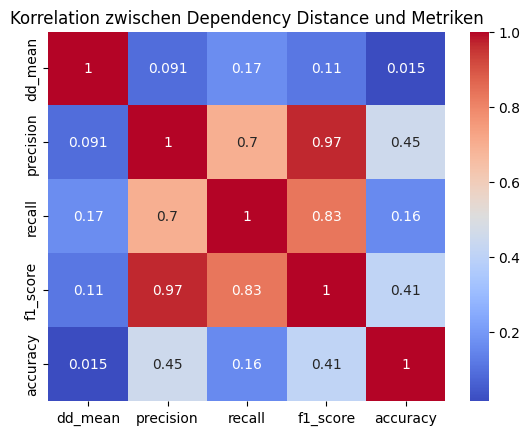

In [308]:
# Korrelation berechnen
correlations = df[['dd_mean', 'precision', 'recall', 'f1_score', 'accuracy']].corr(method= "pearson")

# Heatmap zur Darstellung
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Korrelation zwischen Dependency Distance und Metriken')
plt.show()


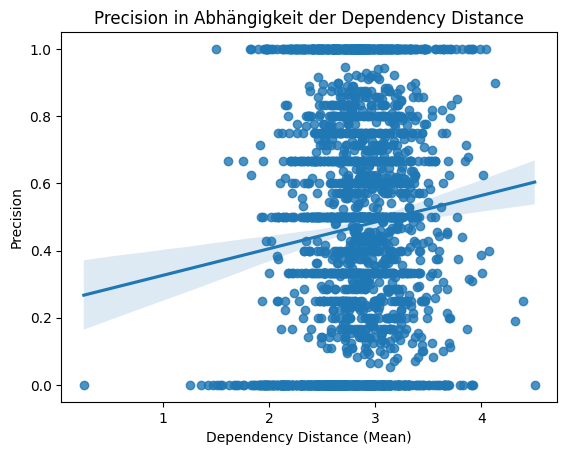

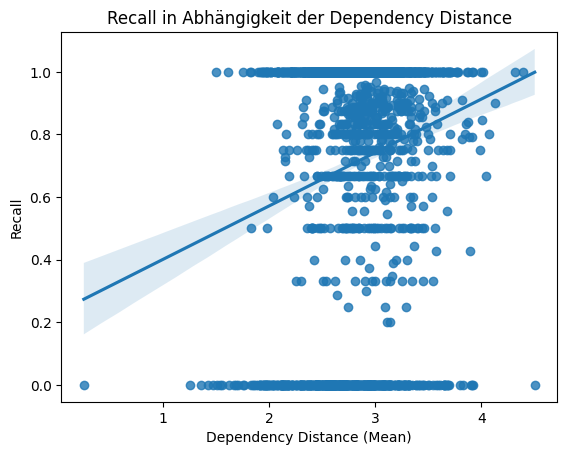

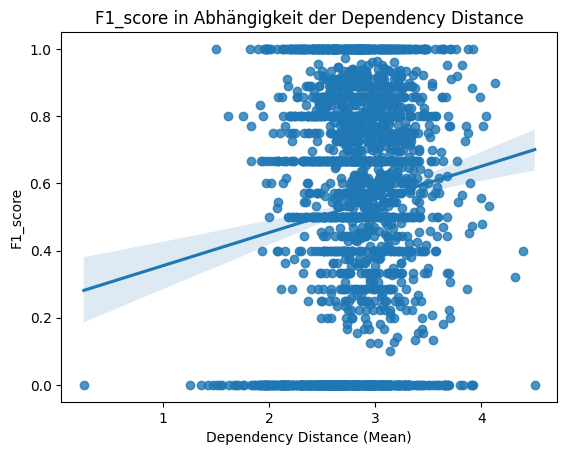

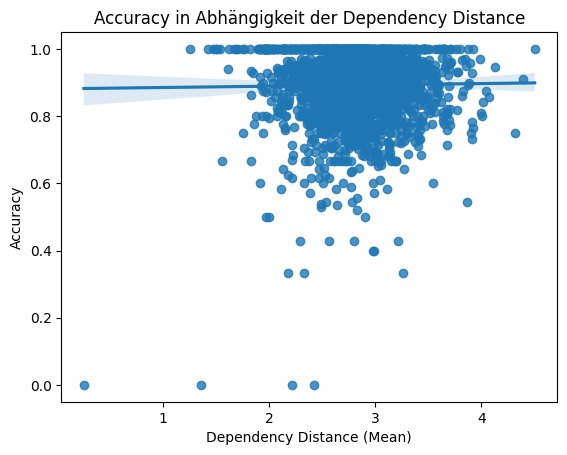

In [309]:
metrics = ["precision", "recall", "f1_score", "accuracy"]

for metric in metrics:
    sns.regplot(data=df, x='dd_mean', y=metric)
    plt.title(f"{metric.capitalize()} in Abhängigkeit der Dependency Distance")
    plt.xlabel("Dependency Distance (Mean)")
    plt.ylabel(metric.capitalize())
    plt.savefig(f"dependency_vs_{metric}.png", dpi=300)
    plt.show()
    plt.close()


## Manuelle Evaluation
einzelne Fehlerfälle werden im Folgenden genauer analysiert um Verbesserungsansät
ze zu entwickeln. Auffällig war die Hohe Zahl der Error messages in generate_possible_corrections sowie bei change Word form. Zunächst mal eine Überprüfung von Wörtern mit Bindestrich.

Es sieht also nach Fehlern in der Vorschlagsgenerierung aus, zum einen mit zusammengesetzten Wörtern (Bergbauern, Taxifahrer, Flugbegleiter) zum Anderen Bei Wörtern mit Bindestrich (Duty-Free-Freunde, Duty-Free-Lobbyisten). 

In [310]:
# Nur die Wörter extrahieren, ohne Position oder Text
words_with_issues = list({
    entry["word"]
    for _, row in df.iterrows()
    for entry in (row["pipeline_result"] if isinstance(row["pipeline_result"], list) else [])
    if entry.get("shouldBeGendered", False) and not entry.get("possibleCorrections")
})
print(sorted(words_with_issues))



['-senatoren', '1600-Tonnen-Segler', '2-Anwender', '500-Dollar-Rechner', 'AA-Chef', 'AEG-Betriebsrat', 'AEG-Betriebsräte', 'Air-France-Chef', 'Amtskirchen-Kritiker', 'Anlagenbauer', 'Anleger', 'Anti-AKW-Aktivisten', 'Anwohner', 'Arbeitnehmer', 'Arzneimittelwächter', 'Asylbewerber', 'Atomkraftgegner', 'Atomtestgegner', 'Atomtestgegnern', 'Aufenthalte', 'Aufenthalten', 'Aufsichtsrat', 'Aufsichtsrates', 'Aufsichtsräte', 'Aufsichtsräten', 'Ausrichter', 'Auszubildende', 'Autofahrer', 'Autokunden', 'BA-Vertreter', 'BKA-Ermittler', 'BKA-Ermittlern', 'BMW-Kunde', 'BUND-Umweltschützer', 'Bafög-Empfängern', 'Beamtenbund-Chef', 'Beaujolais-Winzer', 'Beaujolais-Winzern', 'Belgier', 'Berater', 'Bergbauern', 'Berufskraftfahrer', 'Besitzer', 'Beste', 'Bettelmusikanten', 'Bisamjäger', 'Blumenheiligen', 'Boge-Aktionäre', 'Bonivard-Pilger', 'Briefbeförderer', 'Brummi-Fahrer', 'Bundesgenossen', 'Bundesrat', 'Bundesrates', 'Bundestagsabgeordnete', 'Bären', 'Bündnispartner', 'Büromöbel-Hersteller', 'Büsten

In [311]:

# Zähle für ein bestimmtes Wort ("Anleger") wie oft es mit und ohne Korrekturvorschläge vorkam
zielwort = "Anleger"

mit_korrektur = 0
ohne_korrektur = 0

for _, row in df.iterrows():
    result_list = row["pipeline_result"]
    if isinstance(result_list, list):
        for entry in result_list:
            if (entry.get("word") == zielwort and entry.get("shouldBeGendered", False)):
                if entry.get("possibleCorrections"):
                    mit_korrektur += 1
                else:
                    ohne_korrektur += 1
print(mit_korrektur, ohne_korrektur)

25 2


Machen weitere Stoppworte Sinn? Andere kollektive Ausdrückeprüfen 

In [312]:
for word in [  "etwas", "nichts",
    "mehr", "viele", "wenige", "mehrere",
     "irgendwer", "irgendjemand", "alle", "einer",
    "keiner", "keine", "nichts",
    "irgendwas", "irgendwen", "irgendwem", "niemandem", "jemandes"]:
    liste = df.index[df['pipeline_result'].apply(
        lambda result: any(
            entry.get("word") == word and entry.get("shouldBeGendered", False)
            for entry in (result if isinstance(result, list) else [])
        )
    )].tolist()
    print(word, liste)
    

etwas []
nichts []
mehr []
viele [822]
wenige []
mehrere []
irgendwer []
irgendjemand [1529]
alle []
einer [2, 23, 140, 163, 222, 282, 311, 326, 329, 370, 389, 391, 442, 446, 492, 493, 544, 575, 614, 617, 709, 747, 781, 811, 821, 836, 845, 849, 856, 861, 898, 909, 940, 979, 1033, 1123, 1134, 1165, 1170, 1181, 1195, 1316, 1346, 1395, 1400, 1407, 1467, 1477, 1485, 1495, 1497, 1586, 1602, 1616, 1645, 1685, 1703, 1773, 1844, 1917, 1934, 2037, 2047, 2055, 2070, 2096, 2099, 2103, 2165, 2170, 2176, 2188, 2202, 2208, 2217, 2239, 2259]
keiner [32, 88, 295, 346, 413, 428, 461, 491, 529, 567, 607, 630, 753, 781, 822, 852, 862, 897, 1048, 1131, 1183, 1528, 1602, 1741, 1744, 1750, 1940, 2002, 2103, 2104, 2187]
keine []
nichts []
irgendwas []
irgendwen []
irgendwem [1706]
niemandem []
jemandes []


In [313]:
df.head()


,ArtikelId,Text,Text_unmarked,Sentences_marked,Sentences_unmarked,dependency_distance,marked_word_information,spacified_article,pipeline_result,result_counts,new_language_errors,ntbg_count,error_count,ntbg_to_error_ratio,metrics,dd_mean,precision,recall,f1_score,accuracy
0,ArtikelId: 0001_0001,"""Ross Perot wäre vielleicht ein prächtiger \--...","""Ross Perot wäre vielleicht ein prächtiger Dik...","[""Ross Perot wäre vielleicht ein prächtiger \-...","[""Ross Perot wäre vielleicht ein prächtiger Di...",{'dependency_distance_mean': 2.858281125203935...,"[{'word': 'Diktator', 'from': 43, 'to': 51, 'n...","("", Ross, Perot, wäre, vielleicht, ein, prächt...","[{'word': 'Diktator', 'from': 43, 'to': 51, 'p...","{'marks': 108, 'correct': 79, 'not_ntbg': 95, ...","[Offset 1931, length 4, Rule ID: DE_CASE\nMess...",40,1,40.0,"{'precision': 0.3, 'recall': 0.923076923076923...",2.858281,0.300000,0.923077,0.452830,0.731481
1,ArtikelId: 0001_0002,IBM und Siemens gelten nicht mehr als Schimpfw...,IBM und Siemens gelten nicht mehr als Schimpfw...,[IBM und Siemens gelten nicht mehr als Schimpf...,[IBM und Siemens gelten nicht mehr als Schimpf...,{'dependency_distance_mean': 2.861873114849146...,"[{'word': 'Investoren', 'from': 64, 'to': 74, ...","(IBM, und, Siemens, gelten, nicht, mehr, als, ...","[{'word': 'Investoren', 'from': 64, 'to': 74, ...","{'marks': 83, 'correct': 75, 'ntbg': 8, 'ntbg_...",[],14,0,0.0,"{'precision': 0.5, 'recall': 0.875, 'f1_score'...",2.861873,0.500000,0.875000,0.636364,0.903614
2,ArtikelId: 0001_0003,Wechselspiel von Dramatisierung und Ignoranz\n...,Wechselspiel von Dramatisierung und Ignoranz\n...,"[Wechselspiel von Dramatisierung und Ignoranz,...","[Wechselspiel von Dramatisierung und Ignoranz,...",{'dependency_distance_mean': 3.165174122545213...,"[{'word': 'Politologe', 'from': 49, 'to': 59, ...","(Wechselspiel, von, Dramatisierung, und, Ignor...","[{'word': 'Politologe', 'from': 49, 'to': 59, ...","{'marks': 155, 'correct': 139, 'not_ntbg': 137...",[],11,0,0.0,"{'precision': 0.5833333333333334, 'recall': 0....",3.165174,0.583333,0.388889,0.466667,0.896774
3,ArtikelId: 0001_0004,Im \--Blickpunkt--:\nErmittlungen gegen \--Aut...,Im Blickpunkt:\nErmittlungen gegen Autonome\nS...,"[Im \--Blickpunkt--:, Ermittlungen gegen \--Au...","[Im Blickpunkt:, Ermittlungen gegen Autonome, ...",{'dependency_distance_mean': 3.263254197975927...,"[{'word': 'Blickpunkt', 'from': 3, 'to': 13, '...","(Im, Blickpunkt, :, \n, Ermittlungen, gegen, A...","[{'word': 'Blickpunkt', 'from': 3, 'to': 13, '...","{'marks': 56, 'correct': 50, 'not_ntbg': 47, '...","[Offset 985, length 4, Rule ID: DE_CASE\nMessa...",12,0,0.0,"{'precision': 0.6153846153846154, 'recall': 0....",3.263254,0.615385,0.888889,0.727273,0.892857
4,ArtikelId: 0001_0005,Für ehrliche !--Kunden-- ist es ein \--Schock-...,Für ehrliche Kunden ist es ein Schock\nZahl de...,[Für ehrliche !--Kunden-- ist es ein \--Schock...,"[Für ehrliche Kunden ist es ein Schock, Zahl d...",{'dependency_distance_mean': 2.742601663046218...,"[{'word': 'Kunden', 'from': 13, 'to': 19, 'ntb...","(Für, ehrliche, Kunden, ist, es, ein, Schock, ...","[{'word': 'Kunden', 'from': 13, 'to': 19, 'pos...","{'marks': 78, 'correct': 76, 'ntbg': 12, 'ntbg...",[],12,0,0.0,"{'precision': 0.9166666666666666, 'recall': 0....",2.742602,0.916667,0.916667,0.916667,0.974359


In [314]:
# Extrahiere "not_ntbg_incorrect" aus dem Dictionary in der Spalte "result_counts"
df["not_ntbg_incorrect"] = df["result_counts"].apply(
    lambda d: d.get("not_ntbg_incorrect", 0) if isinstance(d, dict) else 0
)
df["ntbg_incorrect"] = df["result_counts"].apply(
    lambda d: d.get("ntbg_incorrect", 0) if isinstance(d, dict) else 0
)



# Sortiere den DataFrame nach dieser neuen Spalte und wähle die Top 10
top_fp_df = df.sort_values(by="not_ntbg_incorrect", ascending=False).head(10)
top_fn_df = df.sort_values(by="ntbg_incorrect", ascending=False).head(10)

In [315]:
# False Positives sind alle die im Pipeline resultat auf True gesetzt sind - alle die als True markiert wurden
def finde_false_positives(row):
    pipeline_wörter = {
        (eintrag["word"], eintrag['from'])
        for eintrag in row["pipeline_result"]
        if eintrag.get("shouldBeGendered") == True
    }

    marked_wörter = {
        (eintrag["word"],eintrag['from']) for eintrag in row.get("marked_word_information") if eintrag.get("ntbg") == True
    }
    
    return list(pipeline_wörter - marked_wörter)

#False Negatives sind alle die in den Markierungen auf True gesetzt wurden aber nicht im Pipeline resultat waren 
def find_false_negatives_with_explanations(marked, pipeline_result):
    false_negatives = []

    for m in marked:
        if not m.get("ntbg"):
            continue  # nur generische Maskulina

        # Suche nach passendem Eintrag in der Pipeline
        matches = [
            p for p in pipeline_result
            if p.get("from") == m.get("from") and p.get("to") == m.get("to")
        ]

        if not matches:
            # kein Treffer = komplett übersehen
            m["fn_type"] = "nicht erkannt"
            false_negatives.append(m)
        else:
            match = matches[0]
            if match.get("shouldBeGendered") is not True:
                # falsch als nicht generisch eingestuft
                m["fn_type"] = "falsch klassifiziert"
                m["explanation"] = match.get("reasonNotGendered")
                false_negatives.append(m)

    return false_negatives

# Neue Spalte im DataFrame erzeugen (z. B. in top_fp_df oder df)
top_fn_df["false_negatives"] = df.apply(
    lambda row: find_false_negatives_with_explanations(row["marked_word_information"], row["pipeline_result"]),
    axis=1
)
# Neue Spalte mit False Positives anlegen
top_fp_df["false_positives"] = top_fp_df.apply(finde_false_positives, axis=1)

In [316]:
top_fn_df["false_negatives"].iloc[0] 

[{'word': 'Republikaner',
  'from': 80,
  'to': 92,
  'ntbg': True,
  'fn_type': 'falsch klassifiziert',
  'explanation': [(6, 'Keine feminine Wortform gefunden: Republikaner')]},
 {'word': 'Republikaner',
  'from': 1532,
  'to': 1544,
  'ntbg': True,
  'fn_type': 'falsch klassifiziert',
  'explanation': [(6, 'Keine feminine Wortform gefunden: Republikaner')]},
 {'word': 'Republikaner',
  'from': 2093,
  'to': 2105,
  'ntbg': True,
  'fn_type': 'falsch klassifiziert',
  'explanation': [(6, 'Keine feminine Wortform gefunden: Republikaner')]},
 {'word': 'Republikaner',
  'from': 2746,
  'to': 2758,
  'ntbg': True,
  'fn_type': 'falsch klassifiziert',
  'explanation': [(6, 'Keine feminine Wortform gefunden: Republikaner')]},
 {'word': 'Republikaner',
  'from': 3264,
  'to': 3276,
  'ntbg': True,
  'fn_type': 'falsch klassifiziert',
  'explanation': [(6, 'Keine feminine Wortform gefunden: Republikaner')]},
 {'word': 'Republikaner',
  'from': 3439,
  'to': 3451,
  'ntbg': True,
  'fn_type':

In [317]:
output_lines = []

for _, row in top_fp_df.iterrows():
    text = row.get("Text_unmarked", "")
    articleid = row.get("ArtikelId")
    false_positives = sorted(row.get("false_positives", []), key=lambda x: x[1])  # x[1] = from

    offset = 0
    for word, start in false_positives:
        start_adj = start + offset
        end_adj = start_adj + len(word)
        # Einfügen von --...--
        text = text[:start_adj] + "--" + word + "--" + text[end_adj:]
        offset += 4  # zwei Zeichen vorn, zwei hinten

    line = f"{articleid}:\n{text}\n\nFALSE POSITIVES:\n{[w for w, _ in false_positives]}\n"
    output_lines.append(line)
    output_lines.append("\n" + "="*80 + "\n")  # Trenner

# Speichern als Textdatei
output_path = "false_positive_analysen.txt"
with open(output_path, "w", encoding="utf-8") as f:
    f.writelines(output_lines)
    

In [320]:
output_lines = []

for _, row in top_fn_df.iterrows():
    text = row.get("Text_unmarked", "")
    articleid = row.get("ArtikelId")
    false_positives = sorted(row.get("false_negatives", []), key=lambda x: x['from'])
    line = f"{articleid}:\n{text}\n\nFALSE Negatives:\n{false_positives}\n"
    output_lines.append(line)
    output_lines.append("\n" + "="*80 + "\n")  # Trenner zwischen Artikeln

# Speichern als Textdatei
output_path = "false_negative_analyse.txt"
with open(output_path, "w", encoding="utf-8") as f:
    f.writelines(output_lines)